#  Предсказания закрытия стартапов

## Цель проекта
В этом проекте нам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на популярной платформе Kaggle.

В этом конкурсе наша задача - разработать модель для предсказания успешности стартапа (закроется или нет).

__Данные__

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

_Датасеты_:
- kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
- kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.

Поле name - идентификатор (название) стартапа в тестовом наборе, status - целевой признак. Для каждого стартапа нужно предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].

_Признаки датасетов_:

- Описание полей данных
- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

__Оценка качества предсказаний__
Метрикой в этом соревновании является F1-Score. F1-мера вычисляется на основе точности p и полноты r. Точность - это отношение true positives (tp) ко всем predicted positives (tp + fp). Полнота это отношение true positives ко всем actual positives (tp + fn). Тогда F1 задается формулой:

Метрика F1 является гармоническим средним между Recall и Precision. Хорошая модель при обучении будет максимизировать Recall и Precision одновременно. Таким образом, умеренно хорошие показатели по обоим параметрам будут предпочтительнее, чем чрезвычайно хорошие показатели по одному и плохие по другому.


## Загрузка данных

In [1]:
# Устанавливаем необходимые компоненты

!pip install wordcloud -q
!pip install phik -q
#!pip install imbalanced-learn 
#!pip install feature_engine -q

#!pip install sentence-transformers -q
#!pip install --upgrade scikit-learn -q
#!pip install shap -q

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as stb
import math
import os
from IPython.display import display

from wordcloud import WordCloud
import phik


from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.combine import SMOTETomek
from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score

#import shap

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
sns.set_theme(style='darkgrid')
pd.set_option('display.float_format', '{:,.3f}'.format)

In [4]:
# загружаем данные из файлов в датафремы

pth1, pth2, pth3 = (r"datasets\kaggle_startups_train_28062024.csv",
                    r"datasets\kaggle_startups_test_28062024.csv",
                    r"datasets\kaggle_startups_sample_submit_28062024.csv")

if os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3):
    startups_train = pd.read_csv(pth1, sep=',', parse_dates=['founded_at','first_funding_at','last_funding_at','closed_at'])
    startups_test = pd.read_csv(pth2, sep=',', parse_dates=['first_funding_at','last_funding_at'])
    submit_sample = pd.read_csv(pth3, sep=',')

else:
    print('Проверьте правильность написания пути к файлам или их доступность по указанному адресу')

In [5]:
# составляем список датафреймов и их имен
dfs = [startups_train, startups_test, submit_sample]
name_dfs = ['startups_train', 'startups_test', 'submit_sample']

# функция для отображения информации по df, первые строки, типы данных, размер
def data_view(df):
    display(df.head())
    print('\n\033[1mИнформация по составу датафрейма:\033[0m\n')
    df.info()
    print('\n\n')

In [6]:
# цикл для просмотра информации по данным датафремов
def df_view(dfs, name_dfs):
    i = 0
    for df in dfs:
        print(f'\033[1mДатафрейм {name_dfs[i]}:\033[0m')
        data_view(df)
        i += 1

In [7]:
df_view(dfs, name_dfs)

Датафрейм startups_train:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,"22,250,000.000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT



Информация по составу датафрейма:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), flo

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.000",NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,"428,257.000",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.000",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,"4,530,000.000",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209



Информация по составу датафрейма:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB



Датафрейм submit_sample:


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating



Информация по составу датафрейма:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB





In [8]:
min = startups_train['founded_at'].min()
max = startups_train['founded_at'].max()
print(f'Даты открытия самого первого и последнего стартапа в нашем датасете: {min.date()} и {max.date()}')

Даты открытия самого первого и последнего стартапа в нашем датасете: 1970-02-05 и 2016-04-02


### Вывод по загрузке дынных

Загрузили данные, создали датафреймы и просмотрели необходимую информацию, которую будем использовать в проекте. Выяснили, что не будем проводить предобработку данных датафрейма **target_test**, так как он не будет использоваться при обучении или тестировании, а пригодится нам только для формализации формы результатов для дальнейшей загрузки на kaggle и участия в соревновании. Рассмотрели размер датафреймов, типы данных, сразу можно сказать, что необходимо подумать над преобразованием столбцов, которые включают в себя даты и на данный момент представлены типом object. 

По общей информации в датафреймах видно присутствие значительного количества пропусков. На первый взгляд, типы данных в датафреймах определены верно, названия столбцов также соответствуют стандартам. Переходим к предобработке данных.

## Предобработка данных

### Проверка корректности оформления столбцов и типов данных

In [9]:
# функция, которая выдает размер датафрейма
def dfs_size(dfs):
    i = 0
    for df in dfs:    
        print(f'Размер датафрейма \033[1m{name_dfs[i]}\033[0m: строк - {df.shape[0]}, столбцов - {df.shape[1]}')
        i += 1

In [10]:
# убираем из списка образец вывода результатов после обучения модели
dfs = [startups_train, startups_test]
name_dfs = ['startups_train', 'startups_test']

Посмотрим внимательно на названия столбцов датафреймов

In [11]:
for df in dfs:
    display(df.columns)

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime'],
      dtype='object')

Отметим следующие отличия в представленных данных между тренировочным и тестовым датафреймами:

- в train есть столбцы _founded_at_ и _closed at_, но нет _lifetime_ (также нет _status_, так как это таргет);
- в test, наоборот, есть _lifetime_ и нет _founded_at_ и _closed at._

### Анализ пропущенных значений

In [12]:
# Функция, которая выдает размер датафрейма
def dfs_size(dfs):
    i = 0
    for df in dfs:    
        print(f'Размер датафрейма \033[1m{name_dfs[i]}\033[0m: строк - {df.shape[0]}, столбцов - {df.shape[1]}')
        i += 1

In [13]:
# Пишем функцию для отсображения кол-ва, процента пропущенных значений и типа данных
def numb_isna(df, plot):
    isna_types = pd.concat([df.isna().sum(),(df.isna().sum() / df.isna().count() * 100).round(2),
                            df.dtypes],axis=1)
    isna_types.columns = ['sum_isna','percent_isna','value_type']
    isna_types.sort_values(by='sum_isna', ascending=False)

    if plot:
        # Строим тепловую карту
        colours = ['#000000', '#40E0D0'] # определяем цвета, бирюзовый - пропущенные данные, черный - не пропущенные
        fig = plt.subplots(figsize=(12, 6))
        sns.heatmap(df.isna(),cmap=sns.color_palette(colours),cbar= False)
    
        plt.title('Тепловая карта пропусков', fontsize = 14)
        plt.xlabel('Название столбца', fontsize = 12)
        plt.ylabel('Кол-во пропусков', fontsize = 12)
        plt.xticks(rotation=15)
        plt.show();
    
    return isna_types

startups_train:


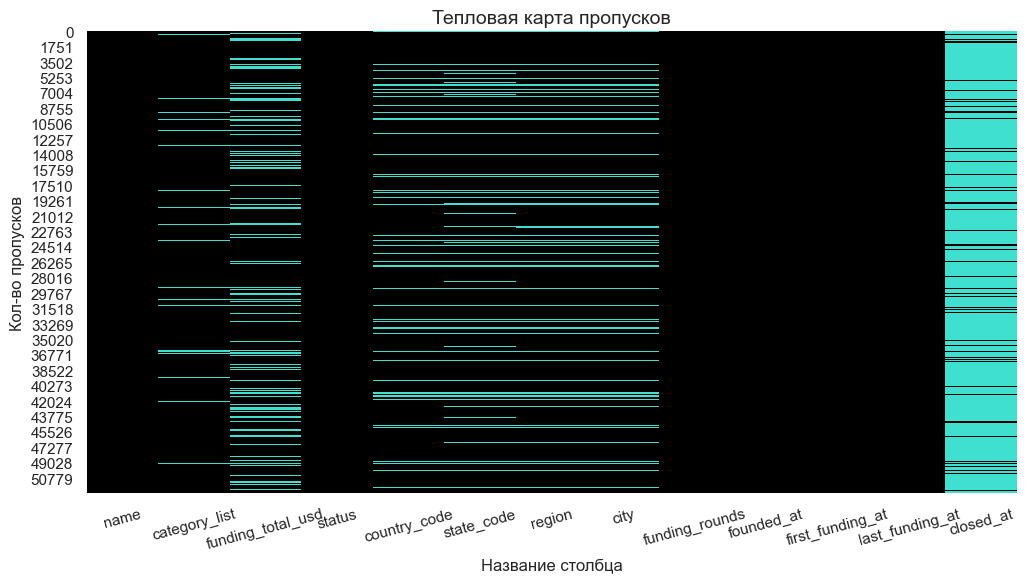

,sum_isna,percent_isna,value_type
name,1,0.000,object
category_list,2465,4.690,object
funding_total_usd,10069,19.170,float64
status,0,0.000,object
country_code,5502,10.480,object
state_code,6763,12.880,object
region,6359,12.110,object
city,6359,12.110,object
funding_rounds,0,0.000,int64
founded_at,0,0.000,datetime64[ns]





startups_test:


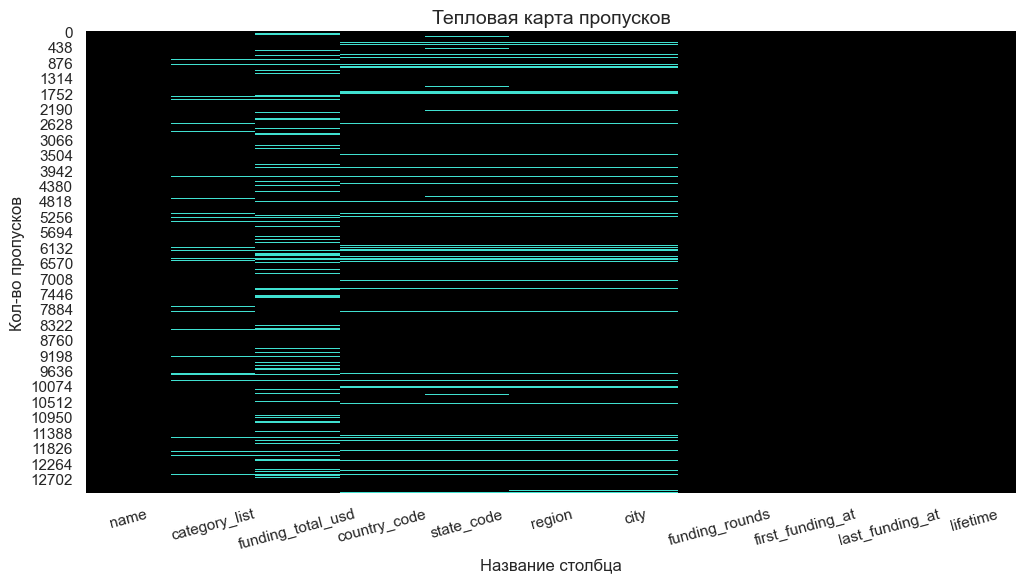

,sum_isna,percent_isna,value_type
name,0,0.000,object
category_list,591,4.500,object
funding_total_usd,2578,19.640,float64
country_code,1382,10.530,object
state_code,1695,12.910,object
region,1589,12.110,object
city,1587,12.090,object
funding_rounds,0,0.000,int64
first_funding_at,0,0.000,datetime64[ns]
last_funding_at,0,0.000,datetime64[ns]


In [14]:
# Выводим таблицу для каждого датафрейма выводим таблицу
j = 0

for df in dfs:
    print(f'\033[1m{name_dfs[j]}:\033[0m')
    display(numb_isna(df,True))
    print('\n\n')
    j += 1

Можно заметить, что процентное соотношение пропусков по столбцам в тренировочной и тестовой выборке очень близко. Начнем разбирать пропуски и с чем они могут быть связаны.

#### Удаление малоинформативных записей

In [15]:
# Проверка данных датафреймов
dfs_size(dfs)

Размер датафрейма startups_train: строк - 52516, столбцов - 13
Размер датафрейма startups_test: строк - 13125, столбцов - 11


Удалим записи, где есть NaN сразу в нескольких полях : _category_list_, _funding_total_usd_, _country_code_, _state_code_, _region_, _city_, так как неясно, помогут ли модели в обучении записи, в которых так мало информации по стартапам.

In [16]:
# dfs[0] = dfs[0].query('not (category_list.isna() and funding_total_usd.isna() and country_code.isna() and city.isna() and region.isna() and state_code.isna())').reset_index(drop=True)
# dfs[0].tail(5)

In [17]:
# dfs[1] = dfs[1].query('not (category_list.isna() and funding_total_usd.isna() and country_code.isna() and city.isna() and region.isna() and state_code.isna())').reset_index(drop=True)
# dfs[1].tail(5)

In [18]:
# Проверка данных датафреймов
dfs_size(dfs)

Размер датафрейма startups_train: строк - 52516, столбцов - 13
Размер датафрейма startups_test: строк - 13125, столбцов - 11


#### Признак closed_at

Мы видим большое количестов пропусков в тренировочной выборки в столбце closed_at, который, скорее всего, связан с тем что стартап еще функционирует. Это можно проверить рассмотрев столбцы с нашим таргетом и датой закрытия.

In [19]:
dfs[0][['name','closed_at','status']].count()

name         52515
closed_at     4917
status       52516
dtype: int64

In [20]:
# количество строк, в которых есть информация о закрытии стартапа
dfs[0][['name','closed_at','status']].query('status == "closed"').count()

name         4916
closed_at    4917
status       4917
dtype: int64

In [21]:
# количество строк, в которых стартап еще на плаву и дата закрытия не равна NaN
dfs[0][['name','closed_at','status']].query('(closed_at.isna() and status == "operating")').count()

name         47599
closed_at        0
status       47599
dtype: int64

In [22]:
dfs[0][['name','closed_at','status']].query('(not closed_at.isna() and status == "operating")').count()

name         0
closed_at    0
status       0
dtype: int64

In [23]:
dfs[0][['name','closed_at','status']].query('(not closed_at.isna() and status == "closed")').count()

name         4916
closed_at    4917
status       4917
dtype: int64

In [24]:
dfs[0][['founded_at','first_funding_at','last_funding_at','closed_at']]

,founded_at,first_funding_at,last_funding_at,closed_at
0,2009-10-17,2011-05-01,2014-12-01,NaT
1,2005-01-01,2010-05-04,2014-02-25,NaT
2,2006-01-01,2012-08-20,2014-07-02,NaT
3,2004-01-01,2011-09-01,2014-07-18,NaT
4,2010-05-12,2012-02-01,2012-02-01,NaT
...,...,...,...,...
52511,2012-01-01,2014-03-01,2014-03-01,NaT
52512,2013-08-25,2014-03-07,2014-03-07,NaT
52513,2010-07-01,2009-06-14,2011-01-01,NaT
52514,1997-12-01,1998-11-30,2004-03-01,NaT


Можно сказать, что наше предположение очень похоже на правду, оставим пропуски как есть, на основе этого столбца в будущем попробуем синтезировать новый признак, а сам столбец удалим.

#### Признаки country_code, state_code, region, city

Далее, мы видим достаточно большое количество пропусков, от 10 до 20 процентов в данных по общей сумме вложенных в стартап средств, коду страны, коду штата, регионе и городе, в котором находится стартап. 

In [25]:
numb_isna(dfs[0][['country_code','state_code','region','city']], False)

,sum_isna,percent_isna,value_type
country_code,5502,10.480,object
state_code,6763,12.880,object
region,6359,12.110,object
city,6359,12.110,object


Для начала, попробуем посмотреть, получится ли на основе города региона или кода штата, восстановить пропущенные значения по странам.

In [26]:
dfs[0][['name','country_code','state_code','region','city']].query('country_code.isna() and not (city.isna() or region.isna() or state_code.isna())')

,name,country_code,state_code,region,city


К сожалению так сделать на получится. Попробуем по городу, определить регион.

In [27]:
dfs[0][['name','country_code','state_code','region','city']].query('region.isna() and not city.isna()')

,name,country_code,state_code,region,city


Таких данных у нас тоже нет.

In [28]:
dfs[0].query('country_code.isna() and city.isna() and state_code.isna() and region.isna()')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,"22,250,000.000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
12,Iberic Premium,NaN,"107,239.000",closed,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10
14,Purewine,Nanotechnology|Technology|Wine And Spirits,"335,000.000",operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaT
15,paack,Customer Service|Delivery|Retail,"30,000.000",operating,NaN,NaN,NaN,NaN,1,2013-04-06,2015-02-01,2015-02-01,NaT
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52444,Plix,Advertising|Digital Media|Games|Social Media|T...,"400,000.000",closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-05-05
52449,ELabsEurope,Internet|Life Sciences|Medical,"20,000,000.000",closed,NaN,NaN,NaN,NaN,1,1999-01-25,2000-10-23,2000-10-23,2002-05-17
52455,Capcom groupe,Construction|Optical Communications|Telecommun...,"10,653,150.249",closed,NaN,NaN,NaN,NaN,1,2014-11-15,2015-09-29,2015-09-29,2017-04-24
52473,Vision Software PTY,NaN,"15,000,000.000",operating,NaN,NaN,NaN,NaN,1,1998-01-10,1999-11-02,1999-11-02,NaT


In [29]:
dfs[0]['country_code'] = dfs[0]['country_code'].fillna('Unknown')
dfs[0]['state_code'] = dfs[0]['state_code'].fillna('Unknown')
dfs[0]['region'] = dfs[0]['region'].fillna('Unknown')
dfs[0]['city'] = dfs[0]['city'].fillna('Unknown')

__Теперь посмотрим на тестовую выборку__

In [30]:
numb_isna(dfs[1][['country_code','state_code','region','city']], False)

,sum_isna,percent_isna,value_type
country_code,1382,10.530,object
state_code,1695,12.910,object
region,1589,12.110,object
city,1587,12.090,object


In [31]:
dfs[1][['name','country_code','state_code','region','city']].query('country_code.isna() and not (city.isna() or region.isna() or state_code.isna())')

,name,country_code,state_code,region,city


In [32]:
dfs[1][['name','country_code','state_code','region','city']].query('region.isna() and not city.isna()')

,name,country_code,state_code,region,city
2300,Readify,AUS,7,NaN,Docklands
6473,Red Crow,PSE,WE,NaN,Ramallah


In [33]:
dfs[1].query('country_code.isna() and city.isna() and state_code.isna() and region.isna()')

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
5,Quickfire Games,Design|Entertainment|Games,"160,000.000",NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
7,Triosyn,Health Care|Medical|Therapeutics,"4,000,000.000",NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576
53,GammaSite,Information Technology|Services|Technology,"3,000,000.000",NaN,NaN,NaN,NaN,1,2000-07-04,2000-07-04,1056
63,siXis,Semiconductors,"8,000,000.000",NaN,NaN,NaN,NaN,2,2008-06-01,2009-10-09,4161
78,beenz.com,Internet|Moneymaking|Online Shopping,NaN,NaN,NaN,NaN,NaN,1,2000-04-01,2000-04-01,7084
...,...,...,...,...,...,...,...,...,...,...,...
13069,Panopticon,Call Center Automation|Real Time|Reviews and R...,NaN,NaN,NaN,NaN,NaN,1,2013-08-13,2013-08-13,1998
13092,Nysa Membrane Technologies,NaN,NaN,NaN,NaN,NaN,NaN,1,2007-10-05,2007-10-05,4307
13100,Hatchery,E-Commerce Platforms|Specialty Foods,"750,000.000",NaN,NaN,NaN,NaN,1,2013-08-01,2013-08-01,1492
13102,Buildingeye,Big Data|Construction|Governments|Internet|Rea...,NaN,NaN,NaN,NaN,NaN,1,2012-02-01,2012-02-01,2192


In [34]:
dfs[1]['country_code'] = dfs[1]['country_code'].fillna('Unknown')
dfs[1]['state_code'] = dfs[1]['state_code'].fillna('Unknown')
dfs[1]['region'] = dfs[1]['region'].fillna('Unknown')
dfs[1]['city'] = dfs[1]['city'].fillna('Unknown')

Обработаем в дальнейшем эти пропуски на шаге обработки данных в пайплайне перед обучением модели. Заменим неизвестные значения на 'Unknown'.

#### Признак category_list

In [35]:
dfs[0].query('category_list.isna()')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
12,Iberic Premium,NaN,"107,239.000",closed,Unknown,Unknown,Unknown,Unknown,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10
16,Salesjob,NaN,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,NaN,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
26,The Center from Health Promotion,NaN,"10,000,000.000",operating,Unknown,Unknown,Unknown,Unknown,1,2002-04-21,2003-11-12,2003-11-12,NaT
64,Seamless Logistics,NaN,NaN,operating,Unknown,Unknown,Unknown,Unknown,1,2009-02-22,2011-02-01,2011-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52404,Beach Bum,NaN,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30
52419,"iSend, LLC",NaN,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2007-01-01,2008-05-28,2008-05-28,2009-10-03
52467,Thermal Nomad,NaN,NaN,operating,USA,TX,Houston,Houston,1,2014-04-20,2014-05-28,2014-05-28,NaT
52473,Vision Software PTY,NaN,"15,000,000.000",operating,Unknown,Unknown,Unknown,Unknown,1,1998-01-10,1999-11-02,1999-11-02,NaT


Около 5% пропусков связано с отсутсвием категории компании-стартапа как в тренировочной так и тестовой выборке, их мы отнесем к категории "Unknown".

In [36]:
dfs[0]['category_list'] = dfs[0]['category_list'].fillna('Unknown')

__Тестовая выборка__

In [37]:
dfs[1].query('category_list.isna()')

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
71,Pangaea Resources,NaN,NaN,AUS,2,Sydney,Sydney,1,2015-08-13,2015-08-13,7670
80,Indie Broadcast Network,NaN,NaN,Unknown,Unknown,Unknown,Unknown,1,2013-07-17,2013-07-17,1162
172,CommunitySift,NaN,"750,000.000",CAN,BC,Kelowna,Kelowna,1,2015-10-29,2015-10-29,2007
186,Desafío Táctico,NaN,NaN,Unknown,Unknown,Unknown,Unknown,1,2013-08-02,2013-08-02,2150
231,Nemo,NaN,NaN,Unknown,Unknown,Unknown,Unknown,1,2015-01-28,2015-01-28,951
...,...,...,...,...,...,...,...,...,...,...,...
13010,TimeGenius,NaN,NaN,CAN,ON,Toronto,Toronto,1,2013-10-31,2013-10-31,1531
13092,Nysa Membrane Technologies,NaN,NaN,Unknown,Unknown,Unknown,Unknown,1,2007-10-05,2007-10-05,4307
13099,Microprogram Information,NaN,NaN,TWN,4,Taiwan,Taichung,1,2015-11-03,2015-11-03,8401
13107,Caspian Impact Investments,NaN,"20,000,000.000",IND,2,Hyderabad,Hyderabad,1,2015-04-02,2015-04-02,1292


In [38]:
dfs[1]['category_list'] = dfs[1]['category_list'].fillna('Unknown')

#### Признак funding_total_usd

Посмотрим внимательнее на взаимосвязь таргета и этого признака, если почти все эти стартапы закрылись, можно предположить, что они так и не получили финансирование.

In [39]:
dfs[0].query('funding_total_usd.isna()')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaT
16,Salesjob,Unknown,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,Unknown,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-03-11,2008-07-15,2008-07-15,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaT
52502,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2007-04-28,2008-01-01,2008-01-01,NaT
52507,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaT
52508,ScramCard,Unknown,NaN,operating,HKG,Unknown,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaT


In [40]:
#dfs[0][['name','status','funding_total_usd']].query('not funding_total_usd.isna() and status == "operating"').count()
#dfs[0][['name','status','funding_total_usd']].query('funding_total_usd.isna() and status == "closed"').count()

percent_closed = (dfs[0]['name'].loc[(dfs[0]['status'] == 'closed') & (dfs[0]['funding_total_usd'].isna())].count() /
                   dfs[0]['name'].loc[dfs[0]['status'] == 'closed'].count() * 100).round(2)
print(f'Доля закрытых стартапов, с значением NaN в поле "funding_total_usd", относительно общего числа закрытых стратапов {percent_closed}%')

Доля закрытых стартапов, с значением NaN в поле "funding_total_usd", относительно общего числа закрытых стратапов 20.85%


In [41]:
percent_closed = (dfs[0]['name'].loc[(dfs[0]['status'] == 'operating') & (dfs[0]['funding_total_usd'].isna())].count() /
                   dfs[0]['name'].loc[dfs[0]['status'] == 'operating'].count() * 100).round(2)
print(f'Доля работающих стартапов, с значением NaN в поле "funding_total_usd", относительно общего числа функционирующих стратапов {percent_closed}%')

Доля работающих стартапов, с значением NaN в поле "funding_total_usd", относительно общего числа функционирующих стратапов 19.0%


Таким образом, мы видим, что доли стартапов, которые продолжают функционировать и имеют значение NaN в графе общей суммы финансирования примерно равны.

In [42]:
dfs[0]['name'].loc[(dfs[0]['status'] == 'operating') & (dfs[0]['funding_total_usd'].isna())].count()

9044

In [43]:
dfs[0]['funding_rounds'].value_counts()

funding_rounds
1     33489
2      9816
3      4450
4      2189
5      1168
6       616
7       341
8       175
9       109
10       63
11       46
12       22
13        9
16        6
15        5
14        5
17        3
18        3
19        1
Name: count, dtype: int64

In [44]:
dfs[0].query('funding_rounds == 1 and not funding_total_usd.isna()')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
5,Connected Sports Ventures,Mobile,"4,300,000.000",operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaT
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,"90,000,000.000",operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaT
7,Mesh Networks,Software,"4,300,000.000",operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaT
11,Seven Seas Water,Clean Technology,"20,000,000.000",operating,USA,FL,Tampa,Tampa,1,1997-01-01,2008-02-04,2008-02-04,NaT
12,Iberic Premium,Unknown,"107,239.000",closed,Unknown,Unknown,Unknown,Unknown,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52501,SociaLive,Software,"5,500.000",operating,USA,CA,SF Bay Area,Stanford,1,2013-09-09,2013-10-25,2013-10-25,NaT
52504,Stratajet,Search,"4,582,414.000",operating,GBR,H9,London,London,1,2010-04-01,2015-06-02,2015-06-02,NaT
52505,IdleAir,Clean Technology,"3,000,000.000",operating,USA,TN,Knoxville,Knoxville,1,2010-04-13,2011-06-23,2011-06-23,NaT
52512,Hello Curry,Hospitality,"500,000.000",operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT


In [45]:
dfs[0].query('funding_rounds == 1 and funding_total_usd.isna() and status == "closed" and first_funding_at == last_funding_at')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
16,Salesjob,Unknown,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,Unknown,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
78,Efficient Photon,Unknown,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2010-02-12,2011-09-22,2011-09-22,2013-08-07
98,WhipCar,Automotive|Online Rental,NaN,closed,GBR,H9,London,London,1,2009-01-01,2009-01-01,2009-01-01,2010-02-02
145,Be Spotted,Advertising|Apps,NaN,closed,USA,FL,Palm Beaches,Palm Beach Gardens,1,2008-01-01,2008-01-01,2008-01-01,2009-04-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52342,AwesomeHighlighter,Curated Web|Information Technology|Social Media,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2007-03-14,2008-08-02,2008-08-02,2009-12-19
52345,P2P Protect Co,Services,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2014-05-20,2015-08-18,2015-08-18,2016-10-05
52404,Beach Bum,Unknown,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30
52419,"iSend, LLC",Unknown,NaN,closed,Unknown,Unknown,Unknown,Unknown,1,2007-01-01,2008-05-28,2008-05-28,2009-10-03


In [46]:
dfs[0][dfs[0]['funding_rounds'] == 1].describe()

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,"24,300.000","33,489.000",33489,33489,33489,3759
mean,"9,302,247.031",1.000,2009-03-09 02:13:59.129265920,2012-01-27 21:29:01.789841408,2012-01-27 21:29:01.789841408,2011-11-09 09:30:47.406224896
min,1.000,1.000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,"150,000.000",1.000,2007-02-17 00:00:00,2010-07-16 00:00:00,2010-07-16 00:00:00,2009-05-27 00:00:00
50%,"860,000.000",1.000,2011-01-01 00:00:00,2013-04-02 00:00:00,2013-04-02 00:00:00,2012-08-11 00:00:00
75%,"4,000,000.000",1.000,2013-02-13 00:00:00,2014-08-25 00:00:00,2014-08-25 00:00:00,2015-07-13 00:00:00
max,"10,664,943,639.000",1.000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-05 00:00:00,2017-10-21 00:00:00
std,"100,420,356.531",0.000,NaN,NaN,NaN,NaN


In [47]:
# # Сгруппируем данные по раунду финансирования, заменим пропуски в общем объеме финансирования на медиану по этим группам
# dfs[0]['funding_total_usd'] = dfs[0].groupby('funding_rounds')['funding_total_usd'].apply(lambda _: _.fillna(_.median()))

In [48]:
dfs[0]['funding_total_usd'] = dfs[0]['funding_total_usd'].fillna(dfs[0].groupby('funding_rounds')['funding_total_usd'].transform('median'))

In [49]:
dfs[0]['funding_total_usd'].isna().sum()

0

In [50]:
dfs[0]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,"22,250,000.000",operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,"860,000.000",operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,"860,000.000",operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT
52512,Hello Curry,Hospitality,"500,000.000",operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT
52513,Taskforce,Email|Messaging|Productivity Software,"50,000.000",operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT
52514,NetScaler,Security,"13,000,000.000",operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT


__Тестовая выборка__

In [51]:
dfs[1].query('funding_total_usd.isna()')

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
10,Omega Discovery Solutions,Consulting|Enterprises,NaN,USA,AZ,Phoenix,Phoenix,1,2014-12-06,2014-12-06,1660
13,Stratics Networks Inc,Call Center Automation|SaaS|Telecommunications...,NaN,USA,AL,Huntsville,Huntsville,1,2013-11-20,2013-11-20,1478
16,Aarki,Advertising|Mobile|Mobile Advertising|Optimiza...,NaN,USA,CA,SF Bay Area,Mountain View,5,2011-06-01,2013-05-01,2670
18,Stroma Medical,Medical,NaN,USA,CA,Anaheim,Laguna Beach,1,2014-05-06,2014-05-06,3197
...,...,...,...,...,...,...,...,...,...,...,...
13108,Thumb Friendly,Mobile,NaN,USA,GA,Atlanta,Atlanta,1,2013-03-07,2013-03-07,2284
13110,"Bloomz, Inc.",Education|Information Technology|Mobile Softwa...,NaN,USA,WA,Seattle,Redmond,3,2014-01-22,2015-11-13,1461
13113,The Fabulous,Apps,NaN,FRA,A8,Paris,Paris,1,2015-03-09,2015-03-09,1273
13114,VIPTALON,Discounts|Fashion|Shopping,NaN,RUS,48,Moscow,Moscow,1,2011-01-13,2011-01-13,2545


In [52]:
dfs[1][dfs[1]['funding_rounds'] == 1].describe()

,funding_total_usd,funding_rounds,first_funding_at,last_funding_at,lifetime
count,"6,082.000","8,449.000",8449,8449,"8,449.000"
mean,"8,307,623.728",1.000,2012-01-21 21:06:29.868623360,2012-01-21 21:06:29.868623360,"2,932.319"
min,1.000,1.000,1973-04-15 00:00:00,1973-04-15 00:00:00,52.000
25%,"150,000.000",1.000,2010-07-23 00:00:00,2010-07-23 00:00:00,"1,522.000"
50%,"884,185.791",1.000,2013-04-01 00:00:00,2013-04-01 00:00:00,"2,192.000"
75%,"4,000,000.000",1.000,2014-08-19 00:00:00,2014-08-19 00:00:00,"3,553.000"
max,"3,500,000,000.000",1.000,2015-12-03 00:00:00,2015-12-03 00:00:00,"17,167.000"
std,"66,281,694.470",0.000,NaN,NaN,"2,220.442"


In [53]:
# # Сгруппируем данные по раунду финансирования, заменим пропуски в общем объеме финансирования на медиану по этим группам
# dfs[1]['funding_total_usd'] = dfs[1].groupby('funding_rounds')['funding_total_usd'].apply(lambda _: _.fillna(_.median())).reset_index(drop=True)

In [54]:
dfs[1]['funding_total_usd'] = dfs[1]['funding_total_usd'].fillna(dfs[1].groupby('funding_rounds')['funding_total_usd'].transform('median'))

In [55]:
dfs[1]['funding_total_usd'].isna().sum()

0

Можно попробовать заполнить пропуски в данных медианой, рассчитанной в зависимости от __раунда проведения инвестиций__, либо заменить на заглушку, сделать это опять же при подготовке данных. Посмотреть какая из моделей покажет себя лучше, при каком изменении данных.

#### Признак name

In [56]:
dfs[0].query('(name.isna())')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,"25,000.000",closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


Один пропуск у нас есть в графе названия компании, мы будем брать название как уникальный идентификатор, так что для нас это столбец критичен, придумаем название этой компании самостоятельно.

In [57]:
dfs[0]['name'] = dfs[0]['name'].fillna('Unknown startap')

In [58]:
dfs[0][dfs[0]['name'] == 'Unknown startap']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,Unknown startap,Startups,"25,000.000",closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


__Тестовая выборка__

In [59]:
dfs[1].query('(name.isna())')

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


В тестовой выборке пропущенных значений в поле имени не обнаружено.

Также, не лишним будет проверить отсутствие совпадений по имени стартапов в тестовой и тренировочной выборке, чтобы не произошло утечки данных.

In [60]:
dfs[0]['name'].isin(dfs[1]['name']).sum()

0

In [61]:
# Выводим таблицу для каждого датафрейма выводим таблицу
j = 0

for df in dfs:
    print(f'\033[1m{name_dfs[j]}:\033[0m')
    display(numb_isna(df,False))
    print('\n\n')
    j += 1

startups_train:


,sum_isna,percent_isna,value_type
name,0,0.000,object
category_list,0,0.000,object
funding_total_usd,0,0.000,float64
status,0,0.000,object
country_code,0,0.000,object
state_code,0,0.000,object
region,0,0.000,object
city,0,0.000,object
funding_rounds,0,0.000,int64
founded_at,0,0.000,datetime64[ns]





startups_test:


,sum_isna,percent_isna,value_type
name,0,0.000,object
category_list,0,0.000,object
funding_total_usd,0,0.000,float64
country_code,0,0.000,object
state_code,0,0.000,object
region,0,0.000,object
city,0,0.000,object
funding_rounds,0,0.000,int64
first_funding_at,0,0.000,datetime64[ns]
last_funding_at,0,0.000,datetime64[ns]


In [62]:
# Проверка данных датафреймов
dfs_size(dfs)

Размер датафрейма startups_train: строк - 52516, столбцов - 13
Размер датафрейма startups_test: строк - 13125, столбцов - 11


### Проверка наличия явных и неявных дубикатов

In [63]:
# Смотрим наличие дубликатов в датафреймах
i = 0

for df in dfs:
    print(f'Количество явных дубликатов до обработки: \033[1m{name_dfs[i]}\033[0m: {df.duplicated().sum()}')
    display(df[df.duplicated()])
    print('-' * 120)
    i += 1

Количество явных дубликатов до обработки: startups_train: 0


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


------------------------------------------------------------------------------------------------------------------------
Количество явных дубликатов до обработки: startups_test: 0


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


------------------------------------------------------------------------------------------------------------------------


Явных дубликатов в данных также не замечено. Посмотрим на неявные дубликаты.

#### Общая проверка неявных дубликатов

In [64]:
# cмотрим уникальные значения по столбцам датафреймов, 
# с целью выявления неявных дубликатов и ошибок, возможных при вводе данных

i = 0
for df in dfs:
    print(f'\033[1m{name_dfs[i]}\033[0m:')
    i += 1
    for col in df.columns:
        print(f'{df[col].name}:\n {df[col].unique()}\n')
        print(f'Количество уникальных значений в поле: \033[1m{df[col].nunique()}\033[0m')
        print('_ _ ' * 50)
    print('\033[1m____\033[0m' * 50)

startups_train:
name:
 ['Lunchgate' 'EarLens' 'Reviva Pharmaceuticals' ... 'Taskforce'
 'NetScaler' 'Apparcando']

Количество уникальных значений в поле: 52516
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
category_list:
 ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']

Количество уникальных значений в поле: 22106
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
funding_total_usd:
 [  828626. 42935019. 35456381. ...  4582414.  3209000.   270820.]

Количество уникальных значений в поле: 15555
_ _ _ _ _ _ _ _ _ _ _ _ _

Убедились, что названия всех стартапов уникальны, это важно, так как именно этот признак послужит нашим уникальным ключом. На первый взгляд, никаких критически важных дубликатов не обнаружено. Однако, заметно очень большое количество уникальных значений, которые описывают направление действия стартапа, а именно 22105 в тренировочной выборке и 6206 в тестовой.

#### Укрупнение групп категорий стартапов

Рассмотрим поподробнее категории стартапов.

In [65]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.width', None)

#dfs[0]['category_list'].unique()
#pd.unique(df['category_list'].values.ravel())

#print(df['category_list'].tolist())

In [66]:
dfs[0]['category_list'] = dfs[0]['category_list'].fillna('Unknown')

In [67]:
dfs[0]['category_list'].value_counts()

category_list
Software                                                                                  3207
Biotechnology                                                                             2905
Unknown                                                                                   2465
E-Commerce                                                                                1064
Mobile                                                                                     920
                                                                                          ... 
iPad|Reviews and Recommendations|Social Television|Software|Television|Video on Demand       1
Graphics|Software|Startups                                                                   1
Curated Web|File Sharing|Graphics|PaaS                                                       1
Cloud Computing|Cloud Data Services|Databases|IaaS|Services|Software|Virtualization          1
Online Rental|Parking|Price Comparis

In [68]:
# словарь для сопоставления новых категорий с ключевыми словами
category_mapping = {
    'Software': ['software', 'soft','app','develop','code'],
    'Biotechnology' : ['biotech','bio'],
    'E-Commerce': ['commerce', 'marketing','shop','logist','consumer','retail','marketplace'],
    'Mobile' : ['mob','phone','android'],
    'Technology' : ['technology','comput','wireless','technol','electro','tech'],
    'Education' : ['curated ','educat','stud','college','universi','school','learn'],
    'Health': ['health', 'care', 'med','hospital','pharmaceut','cosmetics','fitness'],
    'Entertainment' : ['gam','sport','music','travel','video','entertainment','restaurants','audio','film','movie','match','content','book'],
    'Enterprise' : ['enterprise','business','entrepreneur'],
    'Finance': ['finance', 'invest','finan','money','monet','transact','payments','credit'],
    'Manufacturing' : ['semicond','manufact','industrial','engine','oil','gas','fuel','energ','mechanic'],
    'Food': ['food', 'cook','recipe','grocer','farm','fruit'],
    'Security' : ['secur'],
    'Internet' : ['social','internet','search','social','messag','chat'],
    'Services' : ['servic','saas'],
    'Analytics' : ['analyt','data','crm'],
    'Design' : ['architecture','design'],
    'AI' : ['ml','intelect','vision','ai','artificial'],
    'Management' : ['managem','seo'],
    'Real Estate' : ['estate','owner','auction','realtors']
}

# Функция для определения новой категории
def map_category(old_category):
    # Разделяем категории по символу '|'
    categories = old_category.lower().split('|')
    
    # Проверяем каждую категорию на наличие ключевых слов
    for category in categories:
        for new_category, keywords in category_mapping.items():
            # Проверяем наличие хотя бы одного ключевого слова
            if any(keyword in category for keyword in keywords):
                return new_category  # возвращаем новую категорию
    # Если ничего не найдено
    return category.title() # Если ничего не найдено, оставляем старую категорию

# Применяем функцию к столбцу и создаем новый столбец
dfs[0]['enl_category'] = dfs[0]['category_list'].apply(map_category)
dfs[0]['enl_category'].nunique()

290

In [69]:
dfs[0]['enl_category'].unique()

array(['Entertainment', 'Manufacturing', 'Biotechnology', 'Health',
       'Mobile', 'Analytics', 'Software', 'Technology', 'Unknown',
       'Services', 'Finance', 'Internet', 'E-Commerce', 'Education',
       'Environmental Innovation', 'Enterprise', 'Real Estate',
       'Security', 'Fashion', 'Design', 'Management', 'Online Rental',
       'Advertising', 'AI', 'Food', 'Publishing', 'Price Comparison',
       'Life Sciences', 'Alumni', 'Bicycles', '3D Printing',
       'Web Hosting', 'Insurance Companies', 'Telecommunications',
       'Networking', 'Consulting', 'Veterinary', 'Organic',
       'Crowdfunding', 'Startups', 'Pets', 'Water Purification',
       'Utilities', 'Weddings', 'Human Resources', 'Automotive',
       'Recruiting', 'Broadcasting', 'Trading', 'Cannabis',
       'Public Relations', 'Q&A', 'Tea', 'Nonprofits', 'Virtual Currency',
       'Communications Infrastructure', 'Stock Exchanges', 'Real Time',
       'Therapeutics', 'News', 'Home Automation', 'Insurance',
   

__Применим эту функцию также и на тестовую выборку__

In [70]:
# pd.set_option('display.max_rows', 23000)
# cat = dfs[0]['category_list'].value_counts().to_frame()
# #cat.index.tolist()
# cat

In [71]:
dfs[1]['enl_category'] = dfs[0]['category_list'].apply(map_category)
dfs[1]['enl_category'].nunique()

173

In [72]:
dfs[1]['enl_category'].unique()

array(['Entertainment', 'Manufacturing', 'Biotechnology', 'Health',
       'Mobile', 'Analytics', 'Software', 'Technology', 'Unknown',
       'Services', 'Finance', 'Internet', 'E-Commerce', 'Education',
       'Environmental Innovation', 'Enterprise', 'Real Estate',
       'Security', 'Fashion', 'Design', 'Management', 'Online Rental',
       'Advertising', 'AI', 'Food', 'Publishing', 'Price Comparison',
       'Life Sciences', 'Alumni', 'Bicycles', '3D Printing',
       'Web Hosting', 'Insurance Companies', 'Telecommunications',
       'Networking', 'Consulting', 'Veterinary', 'Organic',
       'Crowdfunding', 'Startups', 'Pets', 'Water Purification',
       'Utilities', 'Weddings', 'Human Resources', 'Automotive',
       'Recruiting', 'Broadcasting', 'Trading', 'Cannabis',
       'Public Relations', 'Q&A', 'Tea', 'Nonprofits', 'Virtual Currency',
       'Communications Infrastructure', 'Stock Exchanges', 'Real Time',
       'Therapeutics', 'News', 'Home Automation', 'Insurance',
   

Таким образом, мы сильно сократили число уникальных значений в поле категорий, это разбиение конечно далеко не идеально, но ситуацию улучшает. В дальнейшем, можно доработать разбиение, еще сильнее уменьшить количество категорий, а также попробовать автоматизировать процесс с помощью sentence-transformers или word2vec.

In [73]:
dfs_size(dfs)

Размер датафрейма startups_train: строк - 52516, столбцов - 14
Размер датафрейма startups_test: строк - 13125, столбцов - 12


### Вывод по предобработке данных
__Чем дополнить можно: Перевести даты в формат дат, разделить по вертикальной черте категории компаний__

## Исследовательский анализ данных

### Анализ количественных признаков

Первым делом посмотрим на статистическое описание количественных признаков столбцов датафреймов.

In [74]:
i = 0

for df in dfs:
    print(f'\n\033[1m{name_dfs[i]}\033[0m:')
    display(df.describe())
    
    i += 1


startups_train:


,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,"52,516.000","52,516.000",52516,52516,52516,4917
mean,"14,978,122.113",1.741,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472,2012-01-16 16:14:21.012812544
min,1.000,1.000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,"529,721.250",1.000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-09-18 00:00:00
50%,"1,021,239.000",1.000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-09-15 00:00:00
75%,"7,000,000.000",2.000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-23 00:00:00
max,"30,079,503,000.000",19.000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-21 00:00:00
std,"168,361,283.423",1.375,NaN,NaN,NaN,NaN



startups_test:


,funding_total_usd,funding_rounds,first_funding_at,last_funding_at,lifetime
count,"13,125.000","13,125.000",13125,13125,"13,125.000"
mean,"13,544,334.630",1.714,2011-07-23 20:54:08.640000,2012-06-16 05:03:41.348571392,"3,097.610"
min,1.000,1.000,1973-04-15 00:00:00,1973-04-15 00:00:00,52.000
25%,"501,000.000",1.000,2009-11-16 00:00:00,2011-01-10 00:00:00,"1,726.000"
50%,"1,000,000.000",1.000,2012-08-01 00:00:00,2013-08-21 00:00:00,"2,526.000"
75%,"6,840,683.000",2.000,2014-04-01 00:00:00,2014-11-11 00:00:00,"3,866.000"
max,"4,715,000,000.000",15.000,2015-12-03 00:00:00,2015-12-12 00:00:00,"17,167.000"
std,"82,857,649.493",1.319,NaN,NaN,"2,128.357"


Видим, что присутсвует очень большая разница между медианами и средними значениями в данных по сумме инвестиций, расхождения по количеству раундов, а также наличие выбросов в датафреймах. Перейдем к подробной оценке количественных значений, с визуализацией распределения значений.

#### Тренировочная выборка

In [75]:
df

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,enl_category
0,Crystalsol,Clean Technology,"2,819,200.000",NIC,17,Unknown,Unknown,1,2009-07-01,2009-07-01,3501,Entertainment
1,JBI Fish & Wings,Hospitality,"884,185.791",USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Manufacturing
2,COINPLUS,Finance,"428,257.000",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Biotechnology
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.000",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Health
4,DNA13,Software,"4,530,000.000",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,"28,000.000",USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267,Finance
13121,GlobaTrek,Software,"884,185.791",USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192,Technology
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,"5,600,000.000",USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922,Software
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,"150,000.000",USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386,E-Commerce


In [76]:
# функция для построения гистограммы и диаграммы распределения значений
def plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y_h,x_h,y_b,x_b):

    display(df.describe())
    
    fig, axs = plt.subplots(subplots, 1, figsize=figsize)
    
    j = 0
    i = 0
    for col in columns:
        # определение параметров построения гисторграммы
        sns.histplot(data=df[col], ax=axs[i],bins=bins[j], fill=True)
        axs[i].set_title(title_h[j],fontsize=12)
        axs[i].set_ylabel(y_h[j])
        axs[i].set_xlabel(x_h[j])

        # определение параметров построения boxplot
        i += 1  
        sns.boxplot(x=df[col],showmeans=True, ax=axs[i])
        axs[i].set_title(title_b[j],fontsize=12)
        axs[i].set_ylabel(y_b[j])
        axs[i].set_xlabel(x_b[j])
        
        plt.tight_layout()
        
        if i < subplots:
            i += 1
            j += 1

In [77]:
dfs[0]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,enl_category
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Entertainment
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Biotechnology
3,Sancilio and Company,Health Care,"22,250,000.000",operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,Health
4,WireTough Cylinders,Manufacturing,"860,000.000",operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,"860,000.000",operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,Entertainment
52512,Hello Curry,Hospitality,"500,000.000",operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,Health
52513,Taskforce,Email|Messaging|Productivity Software,"50,000.000",operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,AI
52514,NetScaler,Security,"13,000,000.000",operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,Security


,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,"52,516.000","52,516.000",52516,52516,52516,4917
mean,"14,978,122.113",1.741,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472,2012-01-16 16:14:21.012812544
min,1.000,1.000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,"529,721.250",1.000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-09-18 00:00:00
50%,"1,021,239.000",1.000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-09-15 00:00:00
75%,"7,000,000.000",2.000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-23 00:00:00
max,"30,079,503,000.000",19.000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-21 00:00:00
std,"168,361,283.423",1.375,NaN,NaN,NaN,NaN


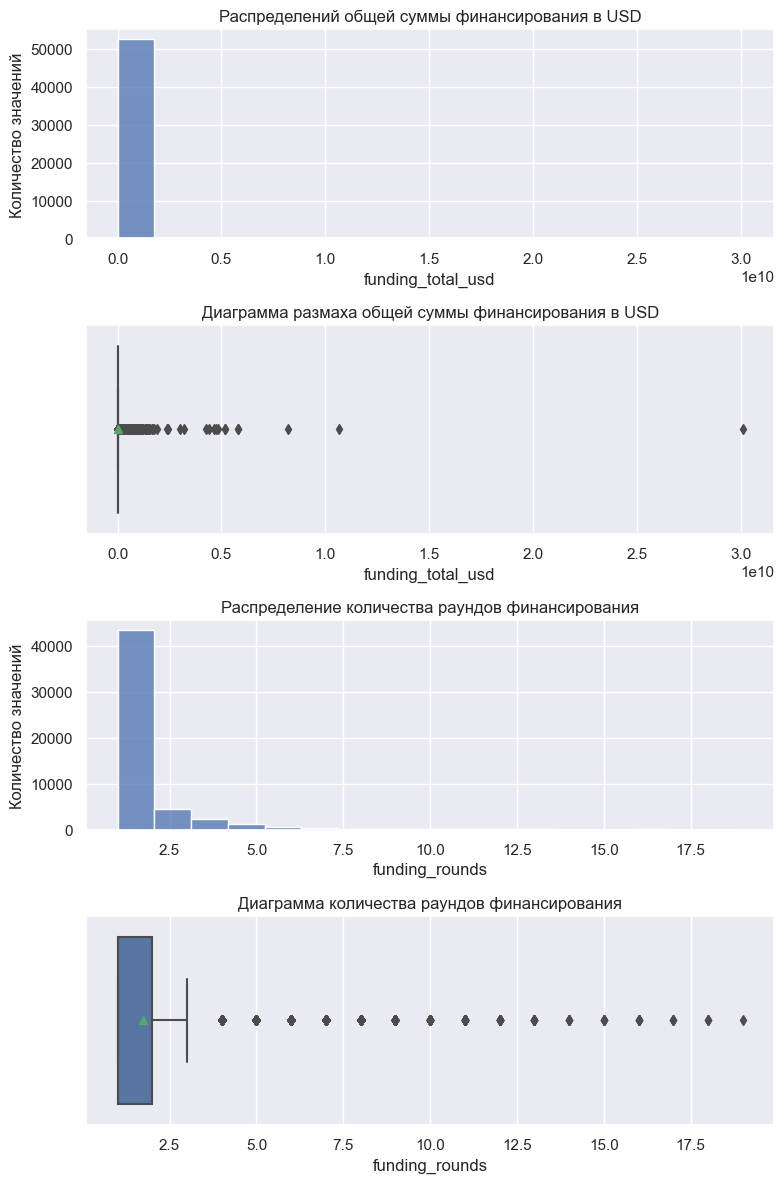

In [78]:
# Создаем переменные, которые станут агрументами функции
df = dfs[0]
columns = df.select_dtypes(include='number').columns.tolist()
col_numb = len(columns)
subplots = col_numb * 2

# Количество корзин определим по правилу Стёрджеса: число bins равно log2(n) + 1, где n - количество наблюдений
bins = [round((math.log2(len(dfs[0])) + 1))] * col_numb
figsize = (8,12)
title_h = ['Распределений общей суммы финансирования в USD','Распределение количества раундов финансирования','Распределение года основания стартапов']
title_b = ['Диаграмма размаха общей суммы финансирования в USD','Диаграмма количества раундов финансирования','Диаграмма размаха лет основания стартапов']
y = ['Количество значений'] * col_numb
x = ['funding_total_usd','funding_rounds','year']
y_b = [''] * col_numb

# Строим графики
plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y,x,y_b,x)

Видим присутствие большого количества выбросов, что говорит нам о большой вариантивности распределения сумм финансирования стартапов, медианное значение расположено в районей 2 млн, при этом среднее около 18 млн. Что касается райндов финансирования, мы также видим большое смещение медианы в сторону 3 квартиля, что говорит нам о  Попробуем отбросить выбросы по общей сумме финансирования превышающие 5 млн, чтобы появилась возможность получше рассмотреть зависимость.

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,"40,439.000","40,439.000",40439,40439,40439,3991
mean,"1,534,953.643",1.415,2009-11-09 00:06:09.623383552,2012-03-13 08:16:44.891317760,2012-09-01 11:09:27.165360128,2012-07-10 11:25:54.196943104
min,1.000,1.000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,"300,000.000",1.000,2008-04-22 12:00:00,2010-11-01 00:00:00,2011-06-08 00:00:00,2010-05-05 12:00:00
50%,"860,000.000",1.000,2011-05-05 00:00:00,2013-01-29 00:00:00,2013-09-04 00:00:00,2013-02-24 00:00:00
75%,"2,000,000.000",2.000,2013-02-01 00:00:00,2014-06-14 00:00:00,2014-11-01 00:00:00,2015-08-05 12:00:00
max,"8,000,000.000",16.000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-11 00:00:00
std,"1,823,440.262",0.870,NaN,NaN,NaN,NaN


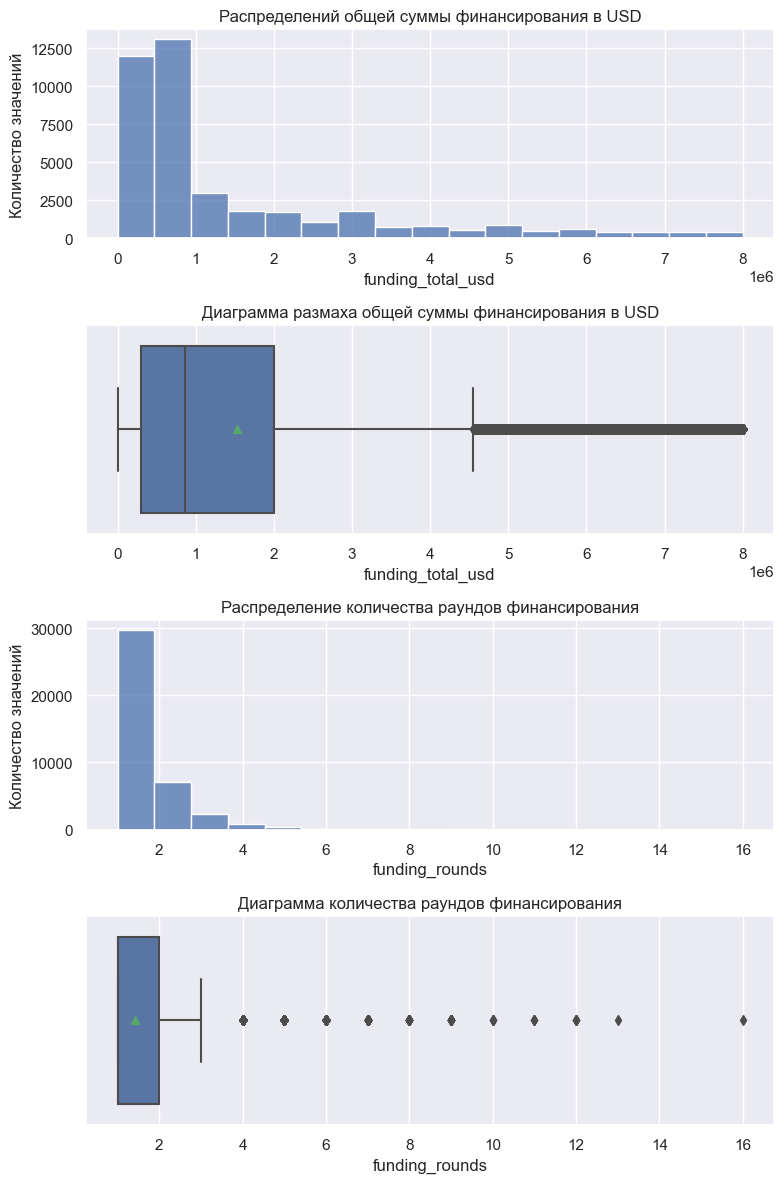

In [79]:
# Создаем переменные, которые станут агрументами функции
df = dfs[0].query('funding_total_usd <= 8_000_000')
columns = df.select_dtypes(include='number').columns.tolist()
col_numb = len(columns)
subplots = col_numb * 2

# Количество корзин определим по правилу Стёрджеса: число bins равно log2(n) + 1, где n - количество наблюдений
bins = [round((math.log2(len(dfs[0])) + 1))] * col_numb
figsize = (8,12)
title_h = ['Распределений общей суммы финансирования в USD','Распределение количества раундов финансирования','Распределение года основания стартапов']
title_b = ['Диаграмма размаха общей суммы финансирования в USD','Диаграмма количества раундов финансирования','Диаграмма размаха лет основания стартапов']
y = ['Количество значений'] * col_numb
x = ['funding_total_usd','funding_rounds','year']
y_b = [''] * col_numb

# Строим графики
plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y,x,y_b,x)

Даже если исключить некоторые значения, мы видим, что медиана смещена к первому квартилю, а разница между средним и медианным значениями объёма финансирования значительна. Это указывает на то, что большинство стартапов в нашей выборке привлекали относительно небольшие суммы инвестиций по сравнению с некоторыми компаниями, которые впоследствии стали гигантами рынка. Однако таких компаний, конечно, гораздо меньше.

Если рассмотреть раунды финансирования, то мы также видим, что медиана сильно смещена к первому квартилю. Это означает, что большинство стартапов проходили небольшое количество раундов. Это подтверждает и медиана, равная единице. Также, можно заметить, что медианный год создания наших стартапо равен 2011 году, большинство представленных стартапов было основано в период с 2006 по 2012 год.

#### Тестовая выборка

,funding_total_usd,funding_rounds,first_funding_at,last_funding_at,lifetime
count,"13,125.000","13,125.000",13125,13125,"13,125.000"
mean,"13,544,334.630",1.714,2011-07-23 20:54:08.640000,2012-06-16 05:03:41.348571392,"3,097.610"
min,1.000,1.000,1973-04-15 00:00:00,1973-04-15 00:00:00,52.000
25%,"501,000.000",1.000,2009-11-16 00:00:00,2011-01-10 00:00:00,"1,726.000"
50%,"1,000,000.000",1.000,2012-08-01 00:00:00,2013-08-21 00:00:00,"2,526.000"
75%,"6,840,683.000",2.000,2014-04-01 00:00:00,2014-11-11 00:00:00,"3,866.000"
max,"4,715,000,000.000",15.000,2015-12-03 00:00:00,2015-12-12 00:00:00,"17,167.000"
std,"82,857,649.493",1.319,NaN,NaN,"2,128.357"


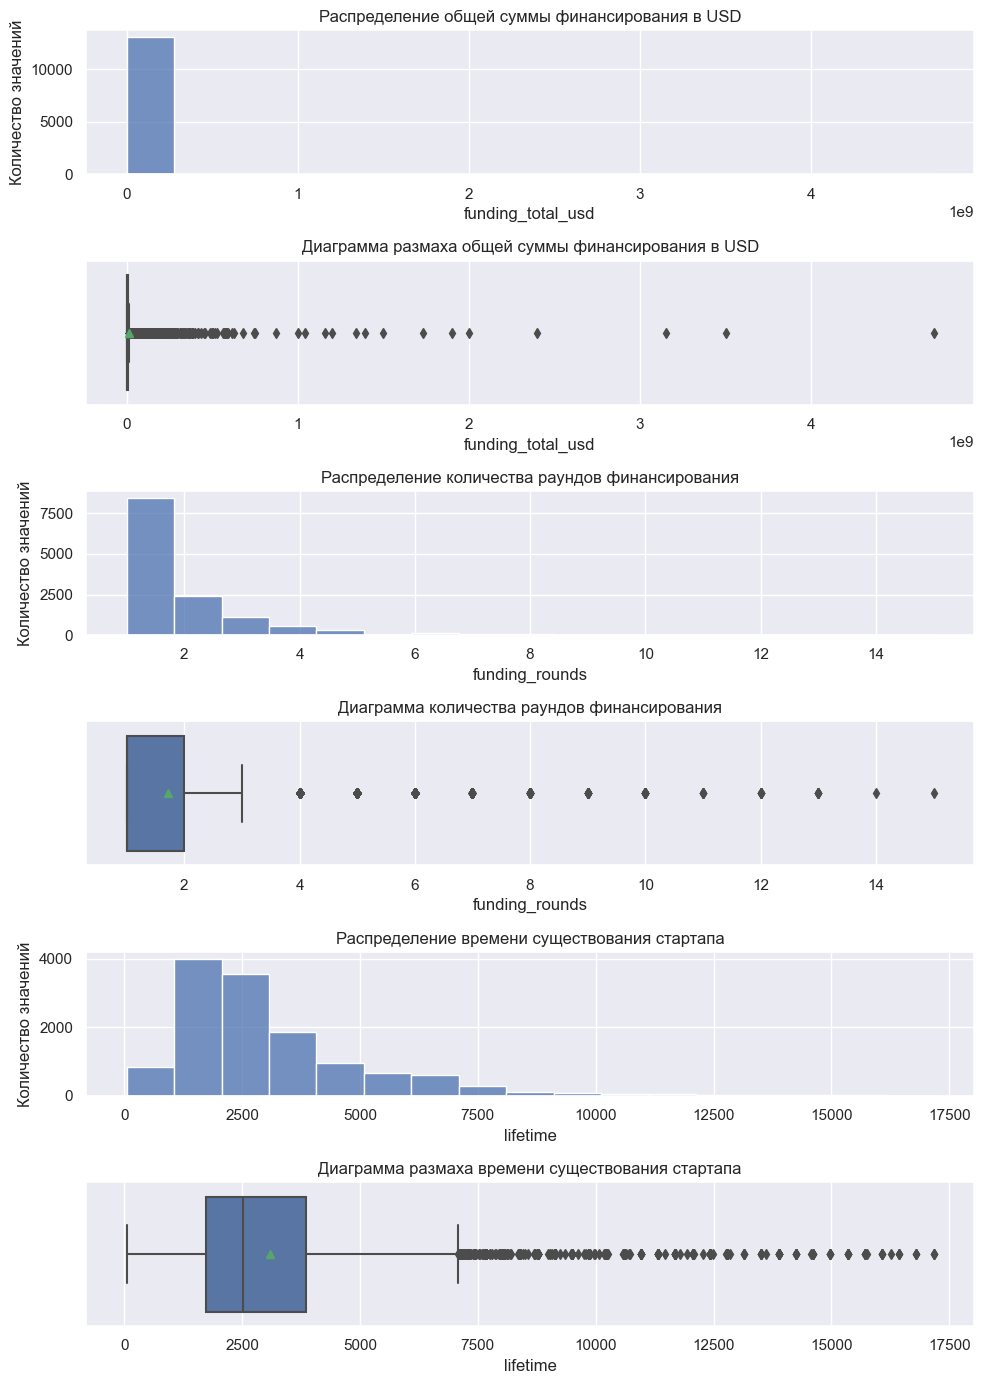

In [80]:
# Создаем переменные, которые станут агрументами функции
df = dfs[1]
columns = df.select_dtypes(include='number').columns.tolist()
col_numb = len(columns)
subplots = col_numb * 2

# Количество корзин определим по правилу Стёрджеса: число bins равно log2(n) + 1, где n - количество наблюдений
bins = [round((math.log2(len(dfs[0])) + 1))] * col_numb
figsize = (10,14)
title_h = ['Распределение общей суммы финансирования в USD','Распределение количества раундов финансирования','Распределение времени существования стартапа'
           ,'Распределение лет основания стартапов']
title_b = ['Диаграмма размаха общей суммы финансирования в USD','Диаграмма количества раундов финансирования','Диаграмма размаха времени существования стартапа',
           'Диаграмма размаха лет основания стартапов']
y = ['Количество значений'] * col_numb
x = ['funding_total_usd','funding_rounds','lifetime','year']
y_b = [''] * col_numb

# Строим графики
plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y,x,y_b,x)

Для тестовой выборки характерны такие же зависимости как и для тренировочной, но поялвляется новый признак, время существования стартапа. Также видим присутсвие большого количества выбросов, смещение медианы к 1 квартилю и существенную разницу со средним, то есть большинство представленных стартапов проживают относительно небольшое количество времени, медиана равна примерно 7 годам. Большинство представленных стартапов было создано в период с 2006 по 2013 годы. Средний год создания стартапов — 2010.

### Анализ категориальных признаков

#### Тренировочная выборка

In [81]:
# Функция, которая строит бары для категориальных признаков датафрейма
def plot_bar(df,columns,value,figsize,title,y,x,color,subplots):
    
    i = 0
    for col in columns:
        # Сводная таблица, на основе которой происходит построение 
        (df.
         pivot_table(index=col, values=value, aggfunc='count')
         .sort_values(by=value, ascending=False).plot(kind='bar', figsize=figsize, color=color[i])
        )
        
        # Оформление графика
        plt.title(title[i], fontsize = 14)
        plt.xlabel(x[i], fontsize = 12)
        plt.ylabel(y[i], fontsize = 12)
        plt.legend('')
        plt.xticks(rotation=0)
        plt.tight_layout()

        if i <= subplots:
            i += 1

In [82]:
def cloud_view(df, col):
    wordcloud = WordCloud(width=600, height=100, background_color ='white').generate_from_frequencies(df[col].value_counts())

    # Настройка визуализации
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    
    # Оформление графика
    plt.title('Облако слов категорий стартапов', fontsize=12)
    plt.axis('off')
    plt.show()

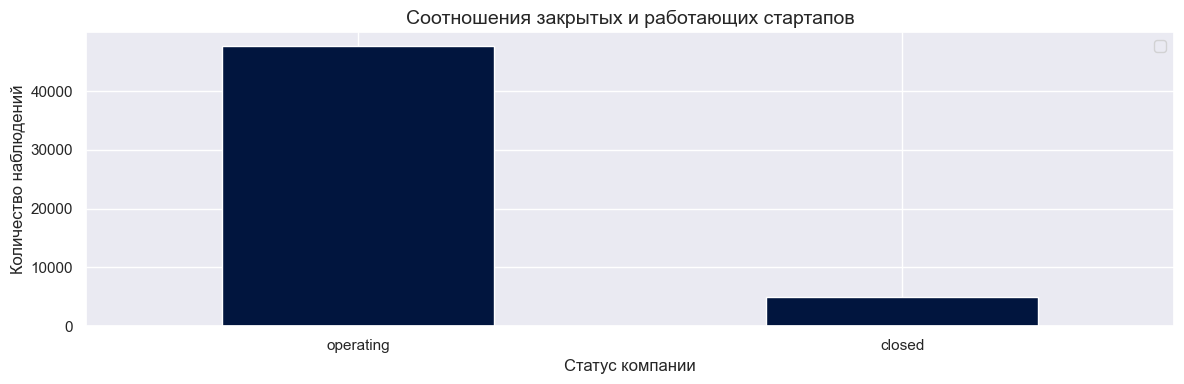

In [83]:
# Переопределяем переменные агрументы функции
df = dfs[0]
columns = ['status']

col_numb = len(columns)
value = 'name'
figsize = (12,4)
title = ['Соотношения закрытых и работающих стартапов']

y = ['Количество наблюдений'] * col_numb
x = ['Статус компании']
color = ['xkcd:navy']

plot_bar(df,columns,value,figsize,title,y,x,color,col_numb)

По диаграмме становится понятно, что в наших датасетах присуствует явный дисбаланс классов, который в последующем обязательно нужно будет учитывать при обучении модели.

Посмотрим на наиболее встречающиеся категории в нашем тренировочном датасете с помощью облака слов.

In [84]:
closed = dfs[0].query('status == "closed"')
operating = dfs[0].query('status == "operating"')        

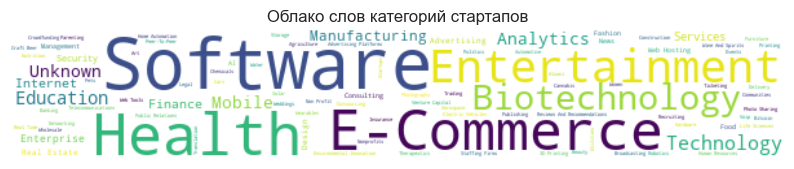

In [85]:
cloud_view(dfs[0], 'enl_category')

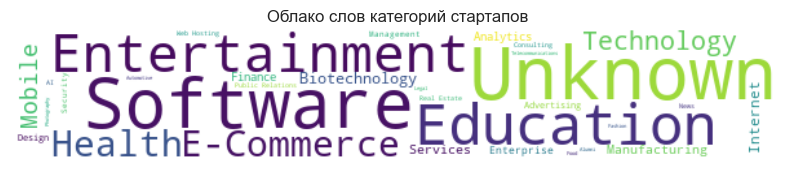

In [86]:
cloud_view(closed, 'enl_category')

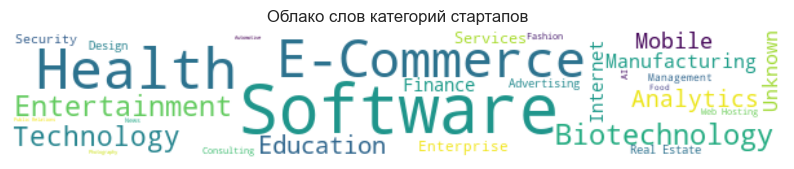

In [87]:
cloud_view(operating, 'enl_category')

Если сравнить количество рабочих и закрытых стартапов в разных категориях, то можно заметить:

* Больше открытых стартапов в категориях биотехнологии и e-commerce.
* Больше закрытых стартапов в образовании, в сферах с неизвестными направлениями деятельности и в технологиях.

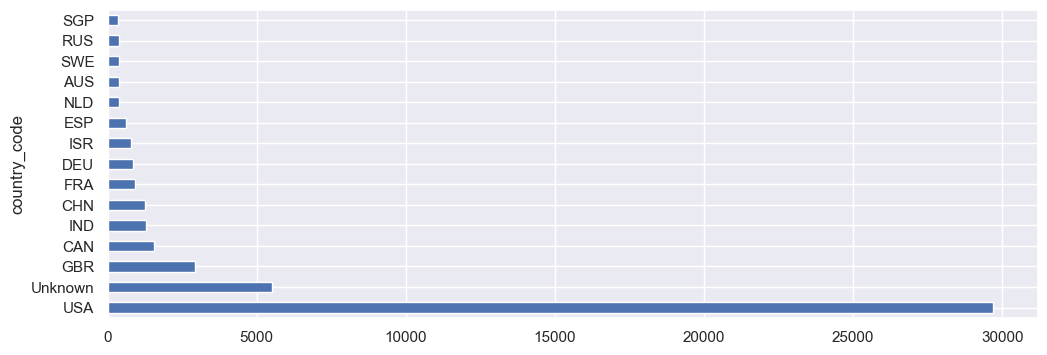

In [88]:
# Смотрим на топ 15 представленных в датасете стран
(
    dfs[0]
    .groupby('country_code')['name']
    .count()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', figsize=figsize)
);

Большая часть стартапов образовалась в США, почти 30000, далее по количеству идут стартапы с неизвестной страной и Великобритания, закрывают топ-6 Канада, Индия и Китай. 

<AxesSubplot:ylabel='country_code'>

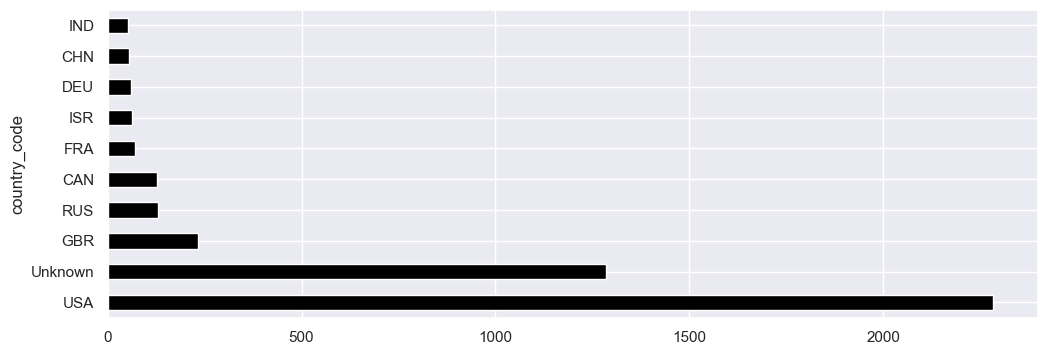

In [89]:
# Смотрим на топ 10 стран, из которых стартапы закрылись
(
    closed
    .groupby('country_code')['name']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', figsize=figsize,color='black')
)

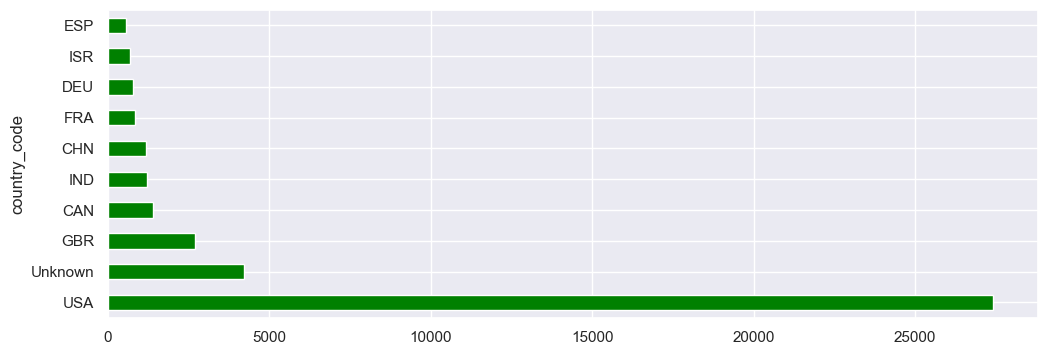

In [90]:
# Смотрим на топ 10 стран, из которых стартапы функционируют
(
    operating
    .groupby('country_code')['name']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', figsize=figsize,color='green')
);

Лидером как по работающим, так и по закрытым стартапам является США, интересно, что в топ 10 по количеству работающих стартапов Россия не входит, но в топе по закрытым стартапам располагается на 4 месте.

#### Тестовая выборка

По диаграмме становится понятно, что в наших датасетах присуствует явный дисбаланс классов, который в последующем обязательно нужно будет учитывать при обучении модели.

Посмотрим на наиболее встречающиеся категории в нашем тренировочном датасете с помощью облака слов.

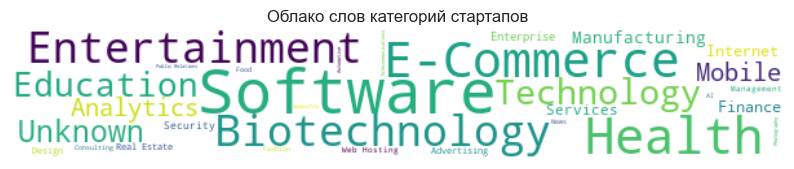

In [91]:
cloud_view(dfs[1], 'enl_category')

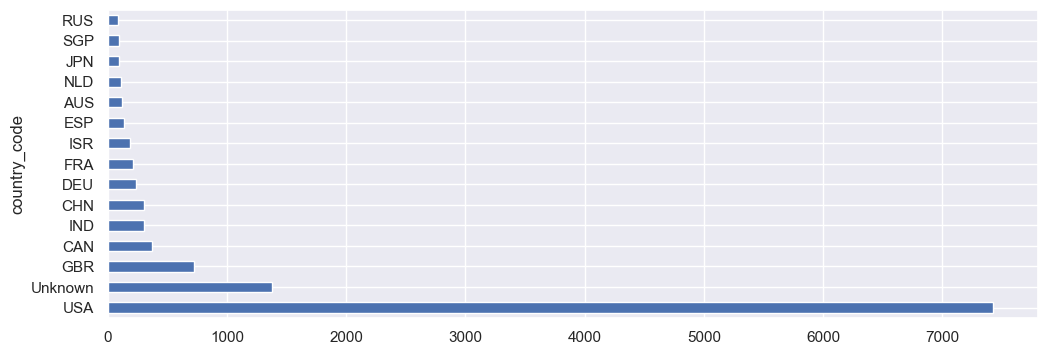

In [92]:
# Смотрим на топ 15 представленных в датасете стран
(
    dfs[1]
    .groupby('country_code')['name']
    .count()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', figsize=figsize)
);

Можно скзаать, что для тестовой выборки характерны те же признаки, что и для тренировочной как в плане категорий, так и в плане стран.

## Создание новых признаков

Перейдем к созданию новых синтетических признаков для наших данных

In [93]:
dfs[0]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,enl_category
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Entertainment
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Biotechnology
3,Sancilio and Company,Health Care,"22,250,000.000",operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,Health
4,WireTough Cylinders,Manufacturing,"860,000.000",operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,"860,000.000",operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,Entertainment
52512,Hello Curry,Hospitality,"500,000.000",operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,Health
52513,Taskforce,Email|Messaging|Productivity Software,"50,000.000",operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,AI
52514,NetScaler,Security,"13,000,000.000",operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,Security


In [94]:
# Создадим новый признак, который будет показывать количество дней с даты основания компании до даты выгрузки
# если у компании есть дата закрытия, то количество дней будет считаться до даты закрытия
unload_date = pd.to_datetime('2018-01-01')

def operating_days(row):
    # Дата выгрузки
    unload_date = pd.to_datetime('2018-01-01')

    # Если дата закрытия NaT, считаем разницу с датой выгрузки
    if pd.isna(row['closed_at']):
        return (unload_date - row['founded_at']).days
    else:
        # Если дата закрытия не NaT, считаем разницу с датой основания
        return (row['closed_at'] - row['founded_at']).days

In [95]:
# Создаем новый столбец с lifetime
dfs[0]['lifetime'] = df.apply(operating_days, axis=1)

In [96]:
# Количество дней с первой даты финансирования до начала выгрузки
dfs[0]['days_from_last_funding'] = (unload_date - dfs[0]['last_funding_at']).dt.days
dfs[1]['days_from_last_funding'] = (unload_date - dfs[1]['last_funding_at']).dt.days

# Количество дней с последней даты раунда финансирования до даты выгрузки
dfs[0]['days_from_first_funding'] = (unload_date - dfs[0]['first_funding_at']).dt.days
dfs[1]['days_from_first_funding'] = (unload_date - dfs[1]['first_funding_at']).dt.days

# Количество дней с первой даты финансирования до последней даты финансирования
dfs[0]['first_to_last_funding'] = (dfs[0]['last_funding_at'] - dfs[0]['first_funding_at']).dt.days
dfs[1]['first_to_last_funding'] = (dfs[1]['last_funding_at'] - dfs[1]['first_funding_at']).dt.days

# Количество раундов на 1 год существования
year=365
dfs[0]['rounds_per_year'] = dfs[0]['funding_rounds'] / (dfs[0]['lifetime'] / year)
dfs[1]['rounds_per_year'] = dfs[1]['funding_rounds'] / (dfs[1]['lifetime'] / year)

# Отношение количества дней, прошедших с последнего финансирования к продолжительности 
# существования стартапа с момента основания до даты выгрузки
dfs[0]['relation_lastf_to_lifetime'] = dfs[0]['days_from_last_funding'] / dfs[0]['lifetime']
dfs[1]['relation_lastf_to_lifetime'] = dfs[1]['days_from_last_funding'] / dfs[1]['lifetime']

# разделить даты по годам на группы с 1970 до 2000, с 2000 по 2006 с 2006 по 2012, с 2012 по 2018

## Корреляционный анализ и финальный отбор признаков

In [97]:
dfs[0].columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'enl_category',
       'lifetime', 'days_from_last_funding', 'days_from_first_funding',
       'first_to_last_funding', 'rounds_per_year',
       'relation_lastf_to_lifetime'],
      dtype='object')

In [98]:
startups_train = dfs[0].drop(['category_list','closed_at','founded_at'],axis=1).set_index('name')
startups_test = dfs[1].drop(['category_list'],axis=1).set_index('name')

In [99]:
startups_train.head(5)

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,enl_category,lifetime,days_from_last_funding,days_from_first_funding,first_to_last_funding,rounds_per_year,relation_lastf_to_lifetime
name,,,,,,,,,,,,,,,,
Lunchgate,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,Entertainment,2998,1127,2437,1310,0.243,0.376
EarLens,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,Manufacturing,4748,1406,2799,1393,0.307,0.296
Reviva Pharmaceuticals,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,Biotechnology,4383,1279,1960,681,0.250,0.292
Sancilio and Company,"22,250,000.000",operating,Unknown,Unknown,Unknown,Unknown,3,2011-09-01,2014-07-18,Health,5114,1263,2314,1051,0.214,0.247
WireTough Cylinders,"860,000.000",operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,Manufacturing,2791,2161,2161,0,0.131,0.774


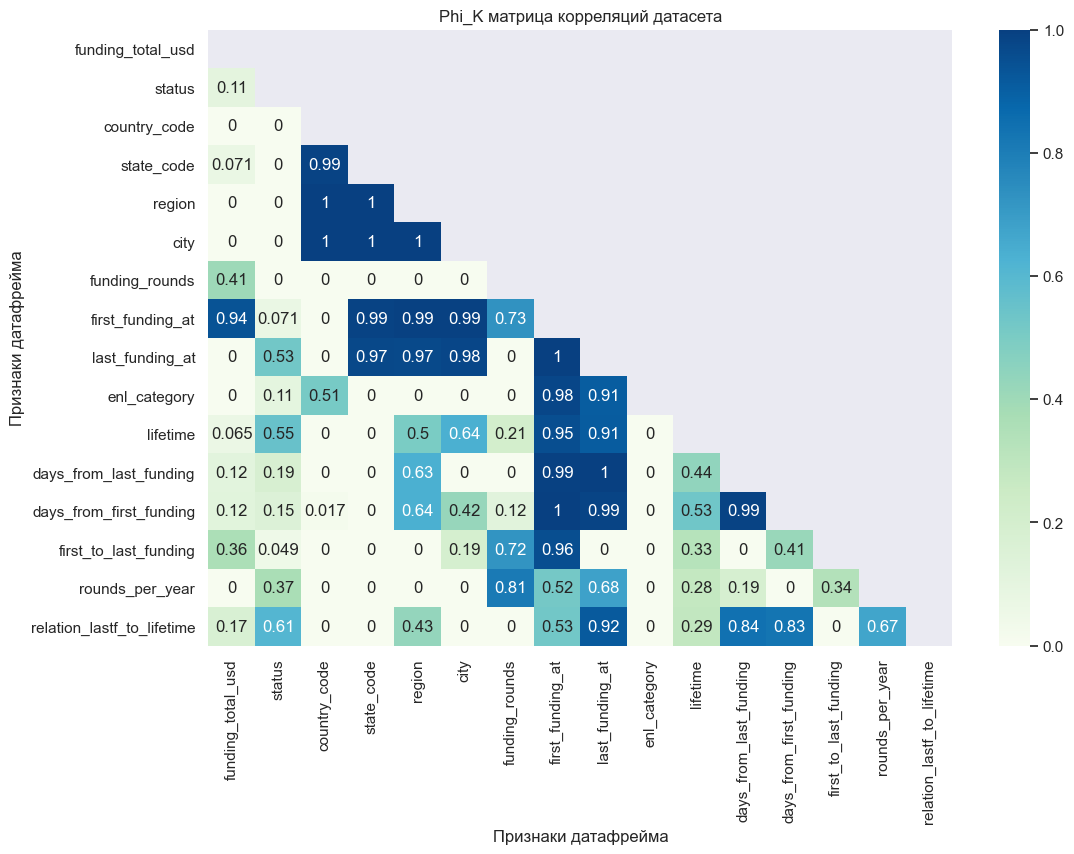

In [100]:
# Соберем выборку из 1500 записей, для ускорения построения матрицы Фи. Сохраним пропорцию значений целевого признака
startups_train_1500, _ = train_test_split(
    startups_train,
    train_size=1000,
    stratify=startups_train['status'],
    random_state=RANDOM_STATE
)

corr_matrix_phik = startups_train_1500.phik_matrix(interval_cols=startups_train_1500.select_dtypes(include='number').columns.tolist())

# Маска для устранения дублирования в визуализации
mask = np.zeros_like(corr_matrix_phik)
mask[np.triu_indices_from(mask)] = True

# Построение heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_phik, annot=True,cmap='GnBu', mask=mask)
plt.title('Phi_K матрица корреляций датасета', fontsize=12)
plt.ylabel('Признаки датафрейма')
plt.xlabel('Признаки датафрейма')
plt.show();

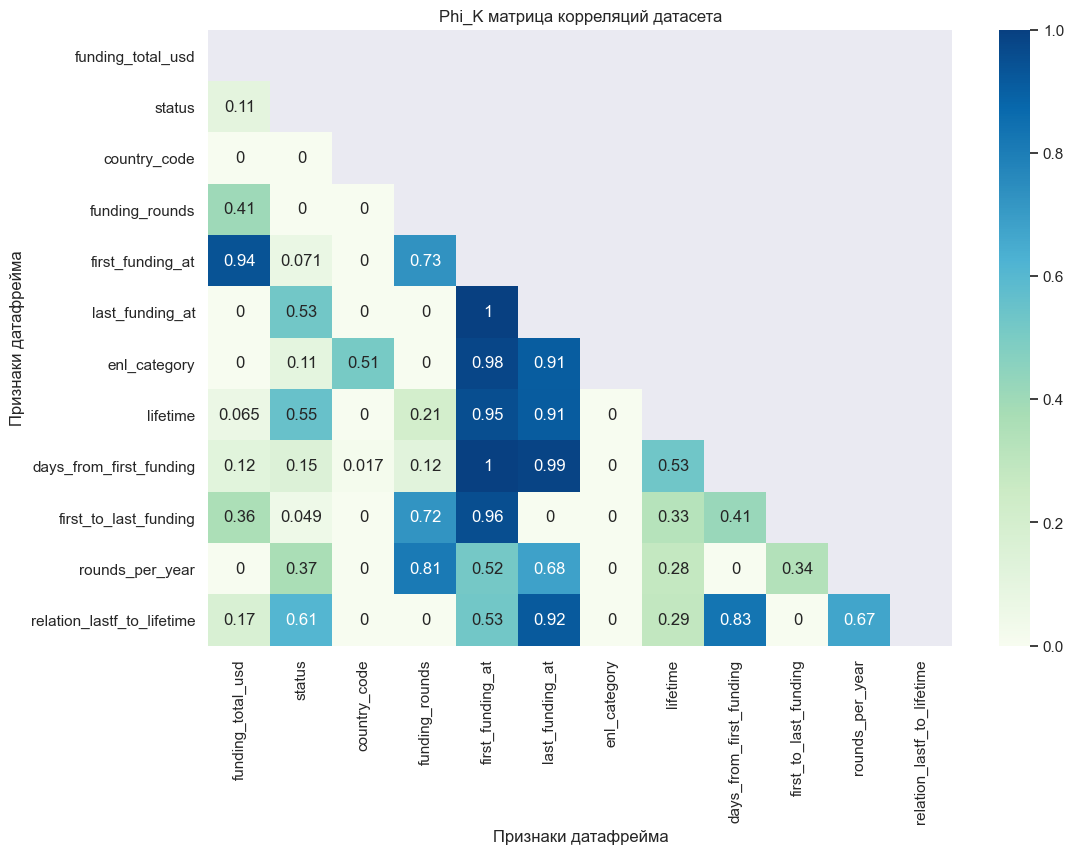

In [101]:
# Соберем выборку из 1500 записей, для ускорения построения матрицы Фи. Сохраним пропорцию значений целевого признака
startups_train_1500, _ = train_test_split(
    startups_train.drop(['city','state_code','region','days_from_last_funding'],axis=1),
    train_size=1000,
    stratify=startups_train['status'],
    random_state=RANDOM_STATE
)

corr_matrix_phik = startups_train_1500.phik_matrix(interval_cols=startups_train_1500.select_dtypes(include='number').columns.tolist())

# Маска для устранения дублирования в визуализации
mask = np.zeros_like(corr_matrix_phik)
mask[np.triu_indices_from(mask)] = True

# Построение heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_phik, annot=True,cmap='GnBu', mask=mask)
plt.title('Phi_K матрица корреляций датасета', fontsize=12)
plt.ylabel('Признаки датафрейма')
plt.xlabel('Признаки датафрейма')
plt.show();

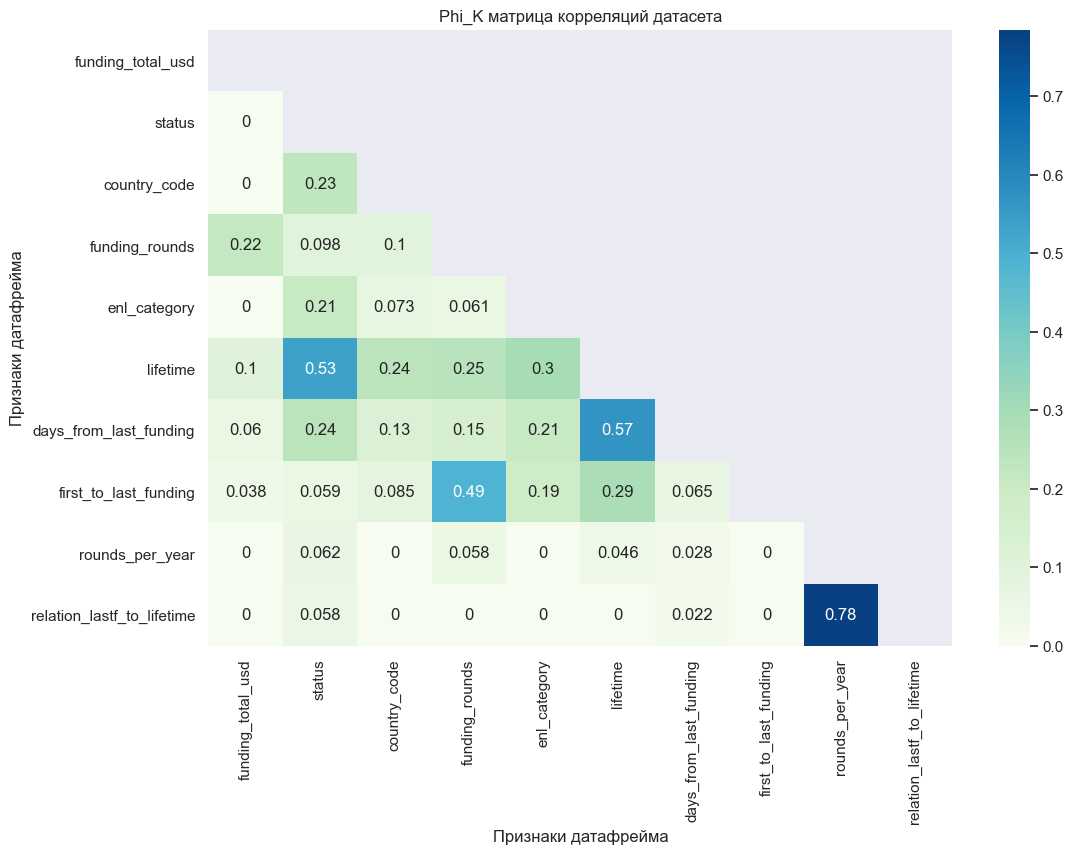

In [102]:
# Соберем выборку из 1500 записей, для ускорения построения матрицы Фи. Сохраним пропорцию значений целевого признака
startups_train_1500, _ = train_test_split(
    startups_train.drop(['city','state_code','region','first_funding_at','last_funding_at','days_from_first_funding'],axis=1),
    train_size=51000,
    stratify=startups_train['status'],
    random_state=RANDOM_STATE
)

corr_matrix_phik = startups_train_1500.phik_matrix(interval_cols=startups_train_1500.select_dtypes(include='number').columns.tolist())

# Маска для устранения дублирования в визуализации
mask = np.zeros_like(corr_matrix_phik)
mask[np.triu_indices_from(mask)] = True

# Построение heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_phik, annot=True,cmap='GnBu', mask=mask)
plt.title('Phi_K матрица корреляций датасета', fontsize=12)
plt.ylabel('Признаки датафрейма')
plt.xlabel('Признаки датафрейма')
plt.show();

__Перенести построение корреляций в функцию__

## Разработка моделей МО

In [103]:
startups_train = startups_train.drop(['city','state_code','region','first_funding_at','last_funding_at','days_from_first_funding'],axis=1)

### Подготовка данных для моделей

In [104]:
startups_train_X = startups_train.drop('status', axis = 1)

# Разбиваем данные на выборки для обучения
X_train, X_test, y_train, y_test = train_test_split(
    startups_train_X, 
    startups_train['status'], 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = startups_train['status'])

# Столбцы для кодирования и масштабирования
ohe_columns = ['country_code','enl_category']
num_columns = startups_train_X.select_dtypes(include='number').columns.tolist()

# Кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [105]:
# Числовые поля
startups_train_X.select_dtypes(include='number').columns.tolist()

['funding_total_usd',
 'funding_rounds',
 'lifetime',
 'days_from_last_funding',
 'first_to_last_funding',
 'rounds_per_year',
 'relation_lastf_to_lifetime']

In [106]:
# Категориальные поля
startups_train_X.select_dtypes(exclude='number').columns.tolist()

['country_code', 'enl_category']

In [107]:
startups_train_X.isna().sum()

funding_total_usd             0
country_code                  0
funding_rounds                0
enl_category                  0
lifetime                      0
days_from_last_funding        0
first_to_last_funding         0
rounds_per_year               0
relation_lastf_to_lifetime    0
dtype: int64

#### Старый пайплайн

In [108]:
# Пайплайн кодирования признаков
ohe_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        )
    ]
)

# Общий пайплан подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', MinMaxScaler(), num_columns)], remainder='passthrough')

# Создаем итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#### Тестирование с помощью imblearn

In [109]:
# num_pipeline = make_imblearn_pipeline(StandardScaler(), DropCorrelatedFeatures(threshold=0.9), DropConstantFeatures(),)
# column_transformer = make_column_transformer((num_pipeline, num_columns),
#                                          (OneHotEncoder(drop='first', sparse=False), ohe_columns),
#                                          remainder='passthrough')

In [110]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [111]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [112]:
X_train

,funding_total_usd,country_code,funding_rounds,enl_category,lifetime,days_from_last_funding,first_to_last_funding,rounds_per_year,relation_lastf_to_lifetime
name,,,,,,,,,
Startlocal,"860,000.000",AUS,1,Unknown,4383,2192,0,0.083,0.500
Full Spectrum Laser,"10,000,000.000",USA,1,Education,3653,1146,0,0.100,0.314
Waywire Networks,"4,584,180.000",USA,8,Education,4383,1655,2332,0.666,0.378
VeryApt,"270,000.000",USA,1,Real Estate,1509,1146,0,0.242,0.759
Vdancer,"860,000.000",SGP,1,E-Commerce,2192,1645,0,0.167,0.750
...,...,...,...,...,...,...,...,...,...
Artesian Solutions,"11,176,477.000",GBR,2,Enterprise,4352,927,1226,0.168,0.213
Biomoda,"1,000,000.000",USA,1,Biotechnology,1503,2848,0,0.243,1.895
tracx,"25,900,000.000",USA,3,Analytics,3471,1064,1082,0.315,0.307


In [113]:
X_test

,funding_total_usd,country_code,funding_rounds,enl_category,lifetime,days_from_last_funding,first_to_last_funding,rounds_per_year,relation_lastf_to_lifetime
name,,,,,,,,,
VISIOGROUP SAS,"392,085.000",FRA,2,Real Estate,1270,1028,238,0.575,0.809
VulevÃº,"40,000.000",ARG,1,E-Commerce,2849,2159,0,0.128,0.758
myCREOpoint,"860,000.000",USA,1,Enterprise,3504,2891,0,0.104,0.825
SWEEPiO,"1,350,000.000",USA,2,Entertainment,2192,1843,441,0.333,0.841
Mix & Meet,"400,000.000",USA,1,Health,1452,3565,0,0.251,2.455
...,...,...,...,...,...,...,...,...,...
Tradono,"7,242,588.000",DNK,3,Health,1341,931,349,0.817,0.694
Zaiseoul,"680,000.000",Unknown,1,Entertainment,2922,1250,0,0.125,0.428
eDepoze,"2,785,000.000",USA,1,Services,2192,852,0,0.167,0.389


### Обучение моделей в пайплайне

In [114]:
# Указание метода для масштабирования числовых признаков в качестве гиперпараметра, также разных моделей МО и их гиперпараметров
params_distr = [
    
    # Словарь для модели DTC
    {
        'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE,class_weight='balanced')],
        'models__max_depth' : range(3,30),
        'preprocessor__num' : [MinMaxScaler(),StandardScaler(),'passthrough']
    },
    
    # # Словарь для модели kNN
    # {
    #     'models' : [KNeighborsClassifier(class_weight='balanced')],
    #     'models__n_neighbors' : range(3,20),
    #     'preprocessor__num' : [MinMaxScaler(),StandardScaler(),'passthrough']
    # },
    
    # Словарь для модели SVC
    # {
    #     'models' : [SVC(random_state=RANDOM_STATE,probability=True,class_weight='balanced')],
    #     'models__kernel' : ['poly','rbf'],
    #     # 'models__degree' : [2,3,4,5],
    #     'preprocessor__num' : [MinMaxScaler(),StandardScaler(),'passthrough']
    # },
    
    # Словарь для модели LogisticRegression
    {
        'models' : [LogisticRegression(random_state=RANDOM_STATE,solver='liblinear',max_iter=1000,class_weight='balanced')],
        'models__C' : range(1, 5),
        'preprocessor__num' : [MinMaxScaler(),StandardScaler(),'passthrough']
    },
]

In [115]:
# Поиск гиперпараметров
randomized = RandomizedSearchCV(
    pipe_final, 
    param_distributions = params_distr,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1,
    random_state=RANDOM_STATE
)

randomized.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized.best_estimator_)
print('Метрика f1 для лучшей модели:\n', round(randomized.best_score_, 5))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'enl_category']),
                                                 ('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'lifetime',
                                                   'days_from_last_funding'

In [116]:
y_pred = randomized.predict(X_test)
print(f'Метрика f1 для лучшей модели RandomizedSearch на валидационной выборке: {round(f1_score(y_test, y_pred), 5)}')

Метрика f1 для лучшей модели RandomizedSearch на валидационной выборке: 0.97847


C:\Users\maksl\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [117]:
pd.Series(y_pred).value_counts()

1    11784
0     1345
Name: count, dtype: int64

In [118]:
X_test

,funding_total_usd,country_code,funding_rounds,enl_category,lifetime,days_from_last_funding,first_to_last_funding,rounds_per_year,relation_lastf_to_lifetime
name,,,,,,,,,
VISIOGROUP SAS,"392,085.000",FRA,2,Real Estate,1270,1028,238,0.575,0.809
VulevÃº,"40,000.000",ARG,1,E-Commerce,2849,2159,0,0.128,0.758
myCREOpoint,"860,000.000",USA,1,Enterprise,3504,2891,0,0.104,0.825
SWEEPiO,"1,350,000.000",USA,2,Entertainment,2192,1843,441,0.333,0.841
Mix & Meet,"400,000.000",USA,1,Health,1452,3565,0,0.251,2.455
...,...,...,...,...,...,...,...,...,...
Tradono,"7,242,588.000",DNK,3,Health,1341,931,349,0.817,0.694
Zaiseoul,"680,000.000",Unknown,1,Entertainment,2922,1250,0,0.125,0.428
eDepoze,"2,785,000.000",USA,1,Services,2192,852,0,0.167,0.389


In [119]:
startups_test = startups_test.drop(['city','state_code','region','first_funding_at','last_funding_at','days_from_first_funding'],axis=1)

In [120]:
cols = list(startups_test.columns)
a, b = cols.index('lifetime'), cols.index('enl_category')
cols[b], cols[a] = cols[a], cols[b]
startups_test = startups_test[cols]

In [121]:
startups_test

,funding_total_usd,country_code,funding_rounds,enl_category,lifetime,days_from_last_funding,first_to_last_funding,rounds_per_year,relation_lastf_to_lifetime
name,,,,,,,,,
Crystalsol,"2,819,200.000",NIC,1,Entertainment,3501,3106,0,0.104,0.887
JBI Fish & Wings,"884,185.791",USA,1,Manufacturing,2717,2714,0,0.134,0.999
COINPLUS,"428,257.000",LUX,2,Biotechnology,1295,1201,126,0.564,0.927
Imagine Communications,"34,700,000.000",USA,4,Health,4748,2813,1935,0.307,0.592
DNA13,"4,530,000.000",CAN,1,Manufacturing,6209,3891,0,0.059,0.627
...,...,...,...,...,...,...,...,...,...
Jymob,"28,000.000",USA,1,Finance,2267,2010,0,0.161,0.887
GlobaTrek,"884,185.791",USA,1,Technology,2192,1553,0,0.167,0.708
Inkd.com,"5,600,000.000",USA,3,Software,2922,2379,1030,0.375,0.814


In [122]:
y_pred_test = randomized.predict(startups_test)
y_pred_test = pd.Series(y_pred_test)
y_pred_test.tail()

C:\Users\maksl\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


13120    1
13121    1
13122    1
13123    1
13124    1
dtype: int32

In [123]:
startups_test_name = startups_test.reset_index()
startups_test_submit = pd.concat([startups_test_name['name'],y_pred_test], axis=1)
startups_test_submit.columns = ['name','status']
startups_test_submit

,name,status
0,Crystalsol,1
1,JBI Fish & Wings,1
2,COINPLUS,1
3,Imagine Communications,1
4,DNA13,1
...,...,...
13120,Jymob,1
13121,GlobaTrek,1
13122,Inkd.com,1
13123,AdWill,1


In [124]:
startups_test_submit['status'] = startups_test_submit['status'].apply(lambda _: 'operating' if _ == 0 else 'closed')
startups_test_submit

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,closed
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,closed
...,...,...
13120,Jymob,closed
13121,GlobaTrek,closed
13122,Inkd.com,closed
13123,AdWill,closed


In [125]:
pd.concat([submit_sample,startups_test_submit], axis=1)

,name,status,name,status
0,Crystalsol,closed,Crystalsol,closed
1,JBI Fish & Wings,operating,JBI Fish & Wings,closed
2,COINPLUS,closed,COINPLUS,closed
3,Imagine Communications,closed,Imagine Communications,closed
4,DNA13,operating,DNA13,closed
...,...,...,...,...
13120,Jymob,operating,Jymob,closed
13121,GlobaTrek,operating,GlobaTrek,closed
13122,Inkd.com,closed,Inkd.com,closed
13123,AdWill,operating,AdWill,closed


In [126]:
submit_sample['status'].value_counts()

status
operating    6635
closed       6490
Name: count, dtype: int64

In [127]:
startups_test_submit['status'].value_counts()

status
closed       11730
operating     1395
Name: count, dtype: int64

### Оценка результатов

## Анализ важности признаков и рекомендации по повышению шанса на успех стартапа

## Общий вывод

Шаги, которые необходимо реализовать:
- [x]  Описать цели проекта, данные, которые будем использовать
- [x]  Загрузить данные, проверить форматы данных и преобразовать, где необходимо
- [x]  Произвести предобработку данных
    - [x]  Проанализировать с пропущенными значениями в признаках, решить как с ними поступить в каждом из случаев
    - [x]  Проверить данные на дубликаты
    - [x]  Значительно уменьшить количество категорий
        - [x] 1)составить список основных категорий и функцию, которая будет сопоставлять данные с этим списком и присавивать нужное значение, затем создать новый столбец на их основе 2) обработать разделив на отдельные категории и работать с этим как с мультикласс-мультилейбл задачей 3) п.2 а потом при этом избавиться от неявных дубликатов (например поискав характерные части слов) 4) п. 3, а затем выбрать топ-N категорий по распространенности
        - [ ] попробовать векторизовать значения через word2vec или sentense-transformers
- [x]  Выполнить исследовательский анализ
- [x]  Синтезировать новые признаки
- [x]  Провести корреляционный анализ данных, убрать утечки таргета, если есть, выполнить окончательный отбор признаков
- [ ]  Создать пайплайн с подготовкой данных
    - [ ] Разобраться с дисбалансом классов, использовать adasync, Smote или SmoteTOMEK  
    - [ ] Обработать каждый из столбцов нужным энекодером
    - [ ] Масшатабировать численные данные
    - [ ]   
- [ ]  Создать пайплайн для обучения моделей
    - [ ] Выбрать какие модели использовать
    - [ ] Подобрать для них гиперпараметры
    - [ ] Не забыть произвести кросс-валидацию и выбрать лучшую
    - [ ] Добавить в каждую из моделей параметр cross_weights = 'balanced'
    - [ ] Зафиксировать метрики на трейне и на тестовой выборке
    - [ ] Построить таблицу истинности и оценить матрицу
- [ ] Сделать оценку важности признаков
- [ ] Привести данные, полученные по лучшей из моделей к нужному виду, для загрузки на Kaggle
- [ ] Сделать отчет с основными этапами работы и выводами, добавить его в Readme
- [ ] Грамотно оформить репозиторий на Github

Комментарии по проекту:
- очень важно поработать с признаками входными, хорошо их обработать
- начало 18 года - дата, после которой мы прогнозируем вероятность закрытия стартапа
- поработать с границей определения классов, по идее, для бизнеса важнее понимать во что вложиться и не прогореть, то есть им нужно максимальное количество результатов TP, а остальные не так важны, то есть нужно отбирать стартапы с самой маленькой вероятностью закрытия(хотя f1 score, по идее, учитывает и то и то)
- сильно несбалансированная целевая переменная, не забывать про проверку дисбаланса классов и модели, для его невилирования можно в моделях используемых использовать параметр (class_weights = balanced), так модель будет больше штрафовать минорный класс, следовательно и больше обращать на него внимение, также посмотреть сэмплирование (adasync, SMOTE, smoteTOMEK)

- проверить на мультиколлинеарность, не забыть убрать утечку целевого признака, она есть, это дата закрытия стартапа
- когда уже перейду к модели, составить план по перебору параметров, не забыть обосновать и лучше делать одно изменение за одну итерацию
- написать отчет общий, как я обычно делаю, перенести его в Readme на github
- не выкладывать на github сами датасеты и сторонние файлы, readme и исполненной тетрадки юпитера будет достаточно
